# 🫀 CNN1D + LSTM para Clasificación Binaria Supervisada de ECG

Este notebook implementa un **CNN1D + LSTM** para clasificación binaria supervisada (ECG normal vs anómalo).

**Características principales:**
- Arquitectura híbrida: CNN1D para extracción de características locales + LSTM para dependencias temporales
- Entrenamiento supervisado con etiquetas (0=normal, 1=anómalo)
- Datos preprocesados desde `Datos_supervisados/tensors_200hz` (archivos .pt)
- Integración con MLflow para tracking de experimentos
- Orquestación con Prefect 2.x
- Soporte automático para GPU (RTX 5080 compatible)

> ⚠️ **IMPORTANTE EN WINDOWS:** Ejecuta la celda de **Setup DLLs CUDA** (celda 2) **ANTES** de la celda de imports. Esto es necesario para que PyTorch pueda cargar las DLLs de CUDA correctamente.

> ▶️ **Instrucciones:** 
> 1. Ejecuta la celda de **Setup DLLs CUDA** primero
> 2. Configura los parámetros en la sección de **CONFIGURACIÓN GENERAL**
> 3. Ajusta la ruta `DATA_DIR` a tu carpeta de datos (debe apuntar a `Datos_supervisados/tensors_200hz`)
> 4. Ejecuta todas las demás celdas en orden


## 📋 Índice

1. **Setup CUDA y dependencias** - Configuración de DLLs y librerías
2. **Configuración general** - Imports, semillas, dispositivo, hiperparámetros
3. **Carga y preparación de datos** - Funciones para cargar desde `tensors_200hz`
4. **Definición del modelo CNN1D + LSTM** - Arquitectura híbrida
5. **Funciones de entrenamiento y evaluación** - Loops de entrenamiento y validación
6. **Integración con MLflow** - Configuración y logging
7. **Orquestación con Prefect** - Flujo principal con Prefect
8. **Ejecución del flujo completo** - Celda final para ejecutar todo
9. **Guardado de modelo** - Exportar modelo estándar y para AWS SageMaker
10. **Prueba de predicciones con ejemplos** - Visualizar predicciones en ejemplos específicos


---

## 1. ⚙️ Setup CUDA y Dependencias


In [1]:
# ========================================
# 🔧 Setup RTX 5080 — dependencias + CUDA DLL
# Ejecuta una sola vez (o tras actualizar drivers/librerías)
# ========================================
import os
import sys
import subprocess
from pathlib import Path
from textwrap import dedent

print(f"Python: {sys.executable}")
print(f"Working dir: {Path.cwd().resolve()}")

# Rutas candidatas para DLLs de CUDA
CUDA_CANDIDATES = [
    os.environ.get("CUDA_PATH"),
    os.environ.get("CUDA_PATH_V12_8"),
    r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8",
    r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8\bin",
    r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8\libnvvp",
    r"C:\Program Files\NVIDIA\CUDNN",
]

# Añadir rutas DLL en Windows (necesario antes de importar torch)
added = []
if hasattr(os, "add_dll_directory"):
    for candidate in CUDA_CANDIDATES:
        if not candidate:
            continue
        path = Path(candidate)
        if path.is_dir():
            try:
                os.add_dll_directory(str(path))
                added.append(str(path))
            except (FileNotFoundError, OSError):
                pass

if added:
    print("DLL directories añadidos:")
    for path in added:
        print(f"  - {path}")

# Instalar dependencias base si no están instaladas
BASE_PACKAGES = [
    "mlflow>=2.16",
    "prefect>=3",
    "scikit-learn",
    "matplotlib",
    "pandas",
    "numpy",
    "seaborn",
    "ipywidgets",
]

def pip_install(spec: str) -> None:
    module_name = spec.split("==")[0].split("[")[0].replace("-", "_")
    try:
        __import__(module_name)
        print(f"✔ {spec} ya instalado")
    except Exception:
        print(f"⏳ Instalando {spec} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", spec])

for pkg in BASE_PACKAGES:
    pip_install(pkg)

# Comando para instalar PyTorch nightly con CUDA 12.8 (para RTX 5080)
TORCH_INSTALL_CMD = [
    sys.executable,
    "-m",
    "pip",
    "install",
    "--upgrade",
    "--pre",
    "torch",
    "torchvision",
    "torchaudio",
    "--index-url",
    "https://download.pytorch.org/whl/nightly/cu128",
]

def ensure_torch_cuda() -> "tuple[object | None, dict]":
    """Importa torch, o instala la nightly cu128 si hace falta."""
    info: dict[str, str | float | bool] = {}
    try:
        import torch  # type: ignore
        info["torch_version"] = getattr(torch, "__version__", "desconocida")
        info["cuda_version"] = getattr(getattr(torch, "version", object()), "cuda", "desconocida")
        info["cuda_available"] = bool(torch.cuda.is_available())
        if "cu128" not in info["torch_version"] and not str(info["cuda_version"]).startswith("12.8"):
            raise RuntimeError(
                f"Build {info['torch_version']} no es cu128. Se reinstalará la nightly para RTX 5080."
            )
        return torch, info
    except Exception as err:
        print("⚠️ Torch no usable todavía:", err)
        print("   Desinstalando PyTorch corrupto...")
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "torch", "torchvision", "torchaudio"])
        print("   Instalando nightly cu128 desde PyTorch (puede tardar).")
        subprocess.check_call(TORCH_INSTALL_CMD)
        print("\n" + "="*60)
        print("⚠️ IMPORTANTE: PyTorch fue reinstalado.")
        print("   DEBES REINICIAR EL KERNEL DE JUPYTER ahora:")
        print("   Kernel → Restart Kernel")
        print("   Luego ejecuta esta celda de nuevo.")
        print("="*60)
        import importlib
        import time
        time.sleep(2)
        importlib.invalidate_caches()
        try:
            import torch  # type: ignore
            info["torch_version"] = getattr(torch, "__version__", "desconocida")
            info["cuda_version"] = getattr(getattr(torch, "version", object()), "cuda", "desconocida")
            info["cuda_available"] = bool(torch.cuda.is_available())
            return torch, info
        except Exception as e2:
            print(f"\n❌ No se pudo importar PyTorch después de reinstalar: {e2}")
            print("   Por favor, REINICIA EL KERNEL y ejecuta esta celda de nuevo.")
            raise RuntimeError("Reinicia el kernel de Jupyter y ejecuta esta celda de nuevo.") from e2

# Intentar importar/instalar PyTorch
torch, torch_info = ensure_torch_cuda()

print("\nTorch info:")
for k, v in torch_info.items():
    print(f"  - {k}: {v}")

if torch_info.get("cuda_available"):
    try:
        gpu_name = torch.cuda.get_device_name(0)
        cc = torch.cuda.get_device_properties(0)
        print(f"GPU detectada: {gpu_name} | SM {cc.major}{cc.minor}")
    except Exception as e:
        print("⚠️ CUDA disponible pero no se pudo consultar GPU:", e)
else:
    print(dedent(
        """
        ⚠️ CUDA sigue inactiva. Revisa drivers / reinicia kernel tras la instalación.
        Si el problema continúa, ejecuta manualmente:
          pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
        """
    ))


Python: c:\Python311\python.exe
Working dir: S:\Proyecto final\Books
DLL directories añadidos:
  - C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8
  - C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8
  - C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8
  - C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8\bin
  - C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8\libnvvp
⏳ Instalando mlflow>=2.16 ...
⏳ Instalando prefect>=3 ...
⏳ Instalando scikit-learn ...
✔ matplotlib ya instalado
✔ pandas ya instalado
✔ numpy ya instalado
✔ seaborn ya instalado
✔ ipywidgets ya instalado

Torch info:
  - torch_version: 2.10.0.dev20251124+cu128
  - cuda_version: 12.8
  - cuda_available: True
GPU detectada: NVIDIA GeForce RTX 5080 | SM 120


In [20]:
# ========================================
# Imports y dependencias
# ========================================
# ⚠️ IMPORTANTE: Ejecuta la celda anterior (Setup DLLs) antes de esta celda
# torch ya está importado en la celda anterior
import random
import json
import time
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# torch ya está importado en la celda anterior, solo importamos los submódulos
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    accuracy_score,
    classification_report,
)
import mlflow
import mlflow.pytorch
from prefect import task, flow
from prefect.tasks import NO_CACHE

# Instalar seaborn si no está disponible (para las visualizaciones de validación)
try:
    import seaborn as sns
except ImportError:
    print("⏳ Instalando seaborn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    import seaborn as sns
    print("✓ seaborn instalado")

print("✓ Todos los imports completados")


✓ Todos los imports completados


---

## 2. ⚙️ Configuración General


In [52]:
# ========================================
# CONFIGURACIÓN GENERAL
# ========================================

# --- Rutas y nombres ---
DATA_DIR = Path("../data/Datos_supervisados/tensors_200hz")  # TODO: Ajustar ruta si es necesario
EXPERIMENT_NAME = "CNN1D_LSTM_ECG_Supervisado_v1"    # Nombre del experimento en MLflow
RUN_NAME = "cnn1d_lstm_ecg_v1"          # Nombre del run en MLflow
OUTPUT_DIR = Path("./outputs")                 # Directorio para guardar artefactos

# --- Datos de entrada ---
N_CHANNELS = 3          # derivaciones de ECG (3 canales)
SEQ_LEN = 2000          # TODO: cantidad de timesteps por ejemplo (ej: 10 s a 200 Hz => 2000)
# INPUT_SIZE se calculará después de las capas CNN (número de features por timestep para la LSTM)

# --- Arquitectura CNN 1D ---
# Cada entrada en estas listas define una capa Conv1d:
# - out_channels_list[i]: filtros de la capa i
# - kernel_sizes[i]: tamaño de kernel para la capa i
# - pool_sizes[i]: tamaño del MaxPool1d posterior (si se usa, None si no se usa)
out_channels_list = [16, 32, 64]   # TODO: ajustar cantidad de filtros por capa
kernel_sizes = [7, 5, 3]           # TODO: ajustar tamaños de kernel
pool_sizes = [2, 2, 2]             # TODO: ajustar factor de pooling por capa (o None si no se usa)

USE_BATCHNORM = True                # si se aplica BatchNorm1d después de cada conv
CNN_ACTIVATION = "relu"             # por ahora usar ReLU
CNN_DROPOUT = 0.1                   # dropout después de cada bloque CNN (opcional)

# --- Arquitectura LSTM ---
HIDDEN_SIZE = 64        # neuronas en la LSTM
NUM_LAYERS = 2          # cantidad de capas LSTM apiladas
DROPOUT = 0.2           # dropout entre capas LSTM (si NUM_LAYERS > 1)

# --- Capa totalmente conectada ---
FC_UNITS = 32           # tamaño de la capa lineal antes de la salida

# --- Entrenamiento ---
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
WEIGHT_DECAY = 1e-5     # regularización L2 (0.0 si no se quiere)
GRADIENT_ACCUMULATION_STEPS = 1
USE_SCHEDULER = True
SCHEDULER_PATIENCE = 3
SCHEDULER_FACTOR = 0.5
SCHEDULER_MIN_LR = 1e-6
SCHEDULER_MODE = 'max'  # Monitorear val_f1_macro (maximizar)
CLIP_GRAD_NORM = 1.0

# --- Otros ---
SEED = 42
USE_CUDA = True         # si hay GPU disponible, usarla
ENABLE_CUDNN_BENCHMARK = True

# --- MLflow ---
MLFLOW_TRACKING_URI = None  # None = usa el directorio local (sqlite:///mlflow.db)

# Crear directorio de salida
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Diccionario de configuración (para pasar a funciones)
CONFIG = {
    "DATA_DIR": DATA_DIR,
    "EXPERIMENT_NAME": EXPERIMENT_NAME,
    "RUN_NAME": RUN_NAME,
    "OUTPUT_DIR": OUTPUT_DIR,
    "N_CHANNELS": N_CHANNELS,
    "SEQ_LEN": SEQ_LEN,
    "out_channels_list": out_channels_list,
    "kernel_sizes": kernel_sizes,
    "pool_sizes": pool_sizes,
    "USE_BATCHNORM": USE_BATCHNORM,
    "CNN_ACTIVATION": CNN_ACTIVATION,
    "CNN_DROPOUT": CNN_DROPOUT,
    "HIDDEN_SIZE": HIDDEN_SIZE,
    "NUM_LAYERS": NUM_LAYERS,
    "DROPOUT": DROPOUT,
    "FC_UNITS": FC_UNITS,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "GRADIENT_ACCUMULATION_STEPS": GRADIENT_ACCUMULATION_STEPS,
    "USE_SCHEDULER": USE_SCHEDULER,
    "SCHEDULER_PATIENCE": SCHEDULER_PATIENCE,
    "SCHEDULER_FACTOR": SCHEDULER_FACTOR,
    "SCHEDULER_MIN_LR": SCHEDULER_MIN_LR,
    "SCHEDULER_MODE": SCHEDULER_MODE,
    "CLIP_GRAD_NORM": CLIP_GRAD_NORM,
    "SEED": SEED,
    "USE_CUDA": USE_CUDA,
    "ENABLE_CUDNN_BENCHMARK": ENABLE_CUDNN_BENCHMARK,
    "MLFLOW_TRACKING_URI": MLFLOW_TRACKING_URI,
}

print("✓ Configuración cargada:")
print(json.dumps({k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()}, indent=2, ensure_ascii=False))


✓ Configuración cargada:
{
  "DATA_DIR": "..\\data\\Datos_supervisados\\tensors_200hz",
  "EXPERIMENT_NAME": "CNN1D_LSTM_ECG_Supervisado_v1",
  "RUN_NAME": "cnn1d_lstm_ecg_v1",
  "OUTPUT_DIR": "outputs",
  "N_CHANNELS": 3,
  "SEQ_LEN": 2000,
  "out_channels_list": [
    16,
    32,
    64
  ],
  "kernel_sizes": [
    7,
    5,
    3
  ],
  "pool_sizes": [
    2,
    2,
    2
  ],
  "USE_BATCHNORM": true,
  "CNN_ACTIVATION": "relu",
  "CNN_DROPOUT": 0.1,
  "HIDDEN_SIZE": 64,
  "NUM_LAYERS": 2,
  "DROPOUT": 0.2,
  "FC_UNITS": 32,
  "BATCH_SIZE": 64,
  "LEARNING_RATE": 0.001,
  "NUM_EPOCHS": 50,
  "WEIGHT_DECAY": 1e-05,
  "GRADIENT_ACCUMULATION_STEPS": 1,
  "USE_SCHEDULER": true,
  "SCHEDULER_PATIENCE": 3,
  "SCHEDULER_FACTOR": 0.5,
  "SCHEDULER_MIN_LR": 1e-06,
  "SCHEDULER_MODE": "max",
  "CLIP_GRAD_NORM": 1.0,
  "SEED": 42,
  "USE_CUDA": true,
  "ENABLE_CUDNN_BENCHMARK": true,
  "MLFLOW_TRACKING_URI": null
}


In [53]:
# ========================================
# Configuración de semillas aleatorias y optimizaciones GPU
# ========================================
def set_seed_everywhere(seed: int = 42, enable_cudnn_benchmark: bool = True) -> None:
    """Fija semillas para reproducibilidad y optimiza GPU."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = enable_cudnn_benchmark
        torch.cuda.empty_cache()
        print(f"✓ cuDNN Benchmark: {'Habilitado' if enable_cudnn_benchmark else 'Deshabilitado'}")

set_seed_everywhere(SEED, enable_cudnn_benchmark=CONFIG.get("ENABLE_CUDNN_BENCHMARK", True))
print(f"✓ Semilla fijada: {SEED}")


✓ cuDNN Benchmark: Habilitado
✓ Semilla fijada: 42


In [54]:
# ========================================
# Configuración de dispositivo (GPU/CPU)
# ========================================
def get_device() -> torch.device:
    """Detecta y configura el dispositivo (GPU si está disponible)."""
    if USE_CUDA and torch.cuda.is_available():
        device = torch.device("cuda")
        gpu_name = torch.cuda.get_device_name(0)
        print(f"✓ GPU detectada: {gpu_name}")
        print(f"  CUDA Version: {torch.version.cuda}")
        print(f"  PyTorch Version: {torch.__version__}")
    else:
        device = torch.device("cpu")
        print("⚠ GPU no disponible, usando CPU")
    return device

DEVICE = get_device()
print(f"Dispositivo seleccionado: {DEVICE}")


✓ GPU detectada: NVIDIA GeForce RTX 5080
  CUDA Version: 12.8
  PyTorch Version: 2.10.0.dev20251124+cu128
Dispositivo seleccionado: cuda


---

## 3. 📂 Carga y Preparación de Datos


In [55]:
# ========================================
# Función para cargar datos desde tensors_200hz (archivos .pt)
# ========================================
def load_tensor_data(
    data_dir: Path,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Carga los datos desde archivos .pt en tensors_200hz.
    
    Args:
        data_dir: Ruta a la carpeta tensors_200hz
        
    Returns:
        Tuple con (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    print("="*70)
    print("📂 CARGANDO DATOS DESDE tensors_200hz")
    print("="*70)
    print(f"Directorio: {data_dir.resolve()}")
    
    # Cargar tensors
    print("\n⏳ Cargando tensors desde disco...")
    X_train = torch.load(data_dir / "X_train.pt", map_location='cpu')
    y_train = torch.load(data_dir / "y_train.pt", map_location='cpu')
    X_val = torch.load(data_dir / "X_val.pt", map_location='cpu')
    y_val = torch.load(data_dir / "y_val.pt", map_location='cpu')
    X_test = torch.load(data_dir / "X_test.pt", map_location='cpu')
    y_test = torch.load(data_dir / "y_test.pt", map_location='cpu')
    
    # Verificar formas
    print(f"\n✓ Datos cargados:")
    print(f"  X_train: {X_train.shape} | y_train: {y_train.shape} (normales: {(y_train==0).sum().item()}, anómalos: {(y_train==1).sum().item()})")
    print(f"  X_val:   {X_val.shape} | y_val:   {y_val.shape} (normales: {(y_val==0).sum().item()}, anómalos: {(y_val==1).sum().item()})")
    print(f"  X_test:  {X_test.shape} | y_test:  {y_test.shape} (normales: {(y_test==0).sum().item()}, anómalos: {(y_test==1).sum().item()})")
    
    # Verificar que las features coincidan con CONFIG
    if X_train.shape[-1] != CONFIG["N_CHANNELS"]:
        print(f"⚠️ ADVERTENCIA: X_train tiene {X_train.shape[-1]} canales, pero N_CHANNELS={CONFIG['N_CHANNELS']}")
        print(f"   Ajustando N_CHANNELS a {X_train.shape[-1]}")
        CONFIG["N_CHANNELS"] = X_train.shape[-1]
    
    # Verificar SEQ_LEN
    if len(X_train.shape) >= 2 and X_train.shape[1] != CONFIG["SEQ_LEN"]:
        print(f"⚠️ ADVERTENCIA: X_train tiene {X_train.shape[1]} timesteps, pero SEQ_LEN={CONFIG['SEQ_LEN']}")
        print(f"   Ajustando SEQ_LEN a {X_train.shape[1]}")
        CONFIG["SEQ_LEN"] = X_train.shape[1]
    
    print("="*70)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


def create_dataloaders_from_tensors(
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_val: torch.Tensor,
    y_val: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
    batch_size: int,
    shuffle_train: bool = True,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Crea DataLoaders desde tensors.
    
    Returns:
        Tuple con (train_loader, val_loader, test_loader)
    """
    # Crear datasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    # Crear dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=0,  # 0 para Windows
        pin_memory=torch.cuda.is_available(),
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=torch.cuda.is_available(),
    )
    
    print(f"\n✓ DataLoaders creados:")
    print(f"  Train: {len(train_loader)} batches ({len(train_dataset)} muestras)")
    print(f"  Val:   {len(val_loader)} batches ({len(val_dataset)} muestras)")
    print(f"  Test:  {len(test_loader)} batches ({len(test_dataset)} muestras)")
    
    return train_loader, val_loader, test_loader


In [56]:
# ========================================
# Clase CNN1D + LSTM para Clasificación Binaria
# ========================================
class CNN1D_LSTMClassifier(nn.Module):
    """
    CNN1D + LSTM para clasificación binaria de series temporales (ECG normal vs anómalo).
    
    Arquitectura:
    - Bloque CNN1D: Extracción de características locales
    - LSTM: Captura de dependencias temporales
    - Capa fully connected
    - Salida binaria (sigmoid)
    """
    
    def __init__(
        self,
        n_channels: int,
        seq_len: int,
        out_channels_list: List[int],
        kernel_sizes: List[int],
        pool_sizes: List[int],
        use_batchnorm: bool = True,
        cnn_activation: str = "relu",
        cnn_dropout: float = 0.0,
        hidden_size: int = 64,
        num_layers: int = 2,
        dropout: float = 0.2,
        fc_units: int = 32,
    ):
        super(CNN1D_LSTMClassifier, self).__init__()
        
        self.n_channels = n_channels
        self.seq_len = seq_len
        self.out_channels_list = out_channels_list
        self.num_cnn_layers = len(out_channels_list)
        
        # ========================================
        # Bloque CNN 1D
        # ========================================
        cnn_layers = []
        in_channels = n_channels
        
        for i in range(self.num_cnn_layers):
            # Conv1d
            cnn_layers.append(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=out_channels_list[i],
                    kernel_size=kernel_sizes[i],
                    padding=(kernel_sizes[i] - 1) // 2,  # padding 'same'
                )
            )
            
            # BatchNorm (si está habilitado)
            if use_batchnorm:
                cnn_layers.append(nn.BatchNorm1d(out_channels_list[i]))
            
            # Activación
            if cnn_activation.lower() == "relu":
                cnn_layers.append(nn.ReLU())
            elif cnn_activation.lower() == "leakyrelu":
                cnn_layers.append(nn.LeakyReLU(0.1))
            else:
                raise ValueError(f"Activación {cnn_activation} no soportada")
            
            # Dropout (opcional)
            if cnn_dropout > 0.0:
                cnn_layers.append(nn.Dropout(cnn_dropout))
            
            # MaxPool (si está definido)
            if pool_sizes[i] is not None and pool_sizes[i] > 1:
                cnn_layers.append(nn.MaxPool1d(kernel_size=pool_sizes[i]))
            
            in_channels = out_channels_list[i]
        
        self.cnn = nn.Sequential(*cnn_layers)
        
        # Calcular tamaño de salida de CNN después del pooling
        # Hacemos un forward dummy para determinar el tamaño de salida
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, seq_len)
            cnn_output = self.cnn(dummy_input)
            # cnn_output shape: (batch, out_channels, seq_len_reduced)
            self.cnn_output_seq_len = cnn_output.shape[2]
            self.cnn_output_channels = cnn_output.shape[1]
        
        # INPUT_SIZE para LSTM = número de canales de salida de CNN
        lstm_input_size = self.cnn_output_channels
        
        # ========================================
        # Bloque LSTM
        # ========================================
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True,
        )
        
        # ========================================
        # Capas Fully Connected
        # ========================================
        self.fc1 = nn.Linear(hidden_size, fc_units)
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(dropout)
        
        # Capa de salida (binaria)
        self.fc2 = nn.Linear(fc_units, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: Tensor de forma (batch_size, seq_len, n_channels) o (batch_size, n_channels, seq_len)
        
        Returns:
            Tensor de forma (batch_size,) con probabilidades
        """
        # Asegurar que x tiene forma (batch_size, n_channels, seq_len) para Conv1d
        if len(x.shape) == 3 and x.shape[1] == self.seq_len and x.shape[2] == self.n_channels:
            # Forma (batch, seq_len, channels) -> transponer a (batch, channels, seq_len)
            x = x.transpose(1, 2)
        # Si ya está en forma (batch, channels, seq_len), no hacer nada
        
        # CNN1D: (batch, channels, seq_len) -> (batch, out_channels, seq_len_reduced)
        cnn_out = self.cnn(x)
        
        # Transponer para LSTM: (batch, out_channels, seq_len_reduced) -> (batch, seq_len_reduced, out_channels)
        cnn_out = cnn_out.transpose(1, 2)
        
        # LSTM: (batch, seq_len_reduced, out_channels) -> (batch, seq_len_reduced, hidden_size)
        lstm_out, (hidden, cell) = self.lstm(cnn_out)
        # Usar el último hidden state de la última capa
        last_hidden = hidden[-1]  # (batch_size, hidden_size)
        
        # Fully connected
        out = self.fc1(last_hidden)
        out = self.relu(out)
        out = self.dropout_fc(out)
        
        # Salida binaria
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out.squeeze(-1)  # (batch_size,)
    
    def predict_proba(self, x: torch.Tensor) -> torch.Tensor:
        """Devuelve probabilidades (mismo que forward)."""
        return self.forward(x)
    
    def predict(self, x: torch.Tensor, threshold: float = 0.6) -> torch.Tensor:
        """Devuelve predicciones binarias."""
        proba = self.forward(x)
        return (proba > threshold).long()


In [57]:
# ========================================
# Instanciar modelo
# ========================================
def create_model(config: Dict) -> CNN1D_LSTMClassifier:
    """Crea e instancia el modelo CNN1D + LSTM."""
    model = CNN1D_LSTMClassifier(
        n_channels=config["N_CHANNELS"],
        seq_len=config["SEQ_LEN"],
        out_channels_list=config["out_channels_list"],
        kernel_sizes=config["kernel_sizes"],
        pool_sizes=config["pool_sizes"],
        use_batchnorm=config["USE_BATCHNORM"],
        cnn_activation=config["CNN_ACTIVATION"],
        cnn_dropout=config["CNN_DROPOUT"],
        hidden_size=config["HIDDEN_SIZE"],
        num_layers=config["NUM_LAYERS"],
        dropout=config["DROPOUT"],
        fc_units=config["FC_UNITS"],
    )
    
    # Contar parámetros
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"✓ Modelo creado:")
    print(f"  Parámetros totales: {total_params:,} ({total_params / 1e6:.2f}M)")
    print(f"  Parámetros entrenables: {trainable_params:,}")
    print(f"  CNN output shape: (batch, {model.cnn_output_channels}, {model.cnn_output_seq_len})")
    print(f"  LSTM input size: {model.cnn_output_channels}")
    
    return model


---

## 5. 🏋️ Funciones de Entrenamiento y Evaluación


In [58]:
# ========================================
# Función de entrenamiento por época
# ========================================
def train_one_epoch(
    model: CNN1D_LSTMClassifier,
    train_loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    gradient_accumulation_steps: int = 1,
    clip_grad_norm: Optional[float] = None,
) -> Tuple[float, float]:
    """
    Entrena el modelo por una época.
    
    Returns:
        Tupla con (loss_promedio, accuracy_promedio)
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    optimizer.zero_grad()
    
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.to(device, non_blocking=True).float()
        
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Normalizar pérdida si usas gradient accumulation
        loss = loss / gradient_accumulation_steps
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping (antes de optimizer.step)
        if clip_grad_norm is not None and clip_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        
        # Actualizar pesos solo cada N pasos (gradient accumulation)
        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # Acumular métricas
        total_loss += loss.item() * batch_x.size(0) * gradient_accumulation_steps
        predictions = (outputs > 0.5).long()
        correct += (predictions == batch_y.long()).sum().item()
        total += batch_x.size(0)
    
    # Actualizar si quedan gradientes pendientes
    if (batch_idx + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    avg_loss = total_loss / total if total > 0 else 0.0
    avg_accuracy = correct / total if total > 0 else 0.0
    
    return avg_loss, avg_accuracy


In [59]:
# ========================================
# Función de evaluación
# ========================================
def evaluate(
    model: CNN1D_LSTMClassifier,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float, np.ndarray, np.ndarray]:
    """
    Evalúa el modelo en un dataloader.
    
    Returns:
        Tupla con (loss, accuracy, y_true, y_pred)
    """
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.to(device, non_blocking=True).float()
            
            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Acumular métricas
            total_loss += loss.item() * batch_x.size(0)
            predictions = (outputs > 0.5).long()
            correct += (predictions == batch_y.long()).sum().item()
            total += batch_x.size(0)
            
            # Guardar predicciones y etiquetas
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(batch_y.long().cpu().numpy())
    
    avg_loss = total_loss / total if total > 0 else 0.0
    avg_accuracy = correct / total if total > 0 else 0.0
    
    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    
    return avg_loss, avg_accuracy, y_true, y_pred


In [60]:
# ========================================
# Función para calcular métricas completas
# ========================================
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calcula métricas completas de clasificación.
    
    Returns:
        Diccionario con todas las métricas
    """
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calcular métricas por clase usando classification_report
    report = classification_report(
        y_true, y_pred,
        target_names=["normal", "anomalo"],
        output_dict=True,
        zero_division=0
    )
    
    # Métricas para clase normal (0)
    metrics_normal = report.get("normal", {})
    precision_normal = metrics_normal.get("precision", 0.0)
    recall_normal = metrics_normal.get("recall", 0.0)
    f1_normal = metrics_normal.get("f1-score", 0.0)
    
    # Métricas para clase anómala (1)
    metrics_anom = report.get("anomalo", {})
    precision_anom = metrics_anom.get("precision", 0.0)
    recall_anom = metrics_anom.get("recall", 0.0)
    f1_anom = metrics_anom.get("f1-score", 0.0)
    
    # Métricas generales (macro avg)
    macro_avg = report.get("macro avg", {})
    precision_macro = macro_avg.get("precision", 0.0)
    recall_macro = macro_avg.get("recall", 0.0)
    f1_macro = macro_avg.get("f1-score", 0.0)
    
    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / max(1, tn + fp)  # TNR
    sensitivity = tp / max(1, tp + fn)   # TPR (recall de clase anómala)
    
    return {
        "accuracy": accuracy,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "precision_normal": precision_normal,
        "recall_normal": recall_normal,
        "f1_normal": f1_normal,
        "precision_anom": precision_anom,
        "recall_anom": recall_anom,
        "f1_anom": f1_anom,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "confusion_matrix": cm,
    }


---

## 6. 📊 Integración con MLflow


In [48]:
# ========================================
# Configuración de MLflow
# ========================================
def setup_mlflow(config: Dict) -> str:
    """
    Configura MLflow y crea/obtiene el experimento.
    
    Returns:
        ID del experimento
    """
    # Configurar tracking URI
    if config.get("MLFLOW_TRACKING_URI") is not None:
        mlflow.set_tracking_uri(config["MLFLOW_TRACKING_URI"])
    else:
        # Usar sqlite en el directorio padre
        PARENT_DIR = Path.cwd().parent.resolve()
        TRACKING_DB = (PARENT_DIR / "mlflow.db").resolve()
        mlflow.set_tracking_uri(f"sqlite:///{TRACKING_DB.as_posix()}")
        print(f"✓ MLflow tracking URI: sqlite:///{TRACKING_DB.as_posix()}")
    
    # Crear o obtener experimento
    experiment_name = config["EXPERIMENT_NAME"]
    
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            # Crear directorio de artefactos
            PARENT_DIR = Path.cwd().parent.resolve()
            ARTIFACT_ROOT = (PARENT_DIR / "mlflow_artifacts").resolve()
            ARTIFACT_ROOT.mkdir(parents=True, exist_ok=True)
            experiment_id = mlflow.create_experiment(experiment_name, artifact_location=ARTIFACT_ROOT.as_uri())
            print(f"✓ Experimento MLflow creado: {experiment_name} (ID: {experiment_id})")
            print(f"  Artifact root: {ARTIFACT_ROOT.as_uri()}")
        else:
            experiment_id = experiment.experiment_id
            print(f"✓ Experimento MLflow existente: {experiment_name} (ID: {experiment_id})")
    except Exception as e:
        print(f"⚠ Error al configurar MLflow: {e}")
        experiment_id = mlflow.set_experiment(experiment_name)
    
    return experiment_id


In [49]:
# ========================================
# Función para guardar matriz de confusión como artefacto
# ========================================
def save_confusion_matrix(
    cm: np.ndarray,
    output_dir: Path,
    tag: str,
) -> Tuple[Path, Path]:
    """
    Guarda la matriz de confusión como PNG y CSV.
    
    Returns:
        Tupla con rutas (png_path, csv_path)
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Guardar como CSV
    csv_path = output_dir / f"confusion_matrix_{tag}.csv"
    df_cm = pd.DataFrame(cm, index=["Normal", "Anómalo"], columns=["Normal", "Anómalo"])
    df_cm.to_csv(csv_path)
    
    # Guardar como PNG
    png_path = output_dir / f"confusion_matrix_{tag}.png"
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    
    # Etiquetas
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]))
    ax.set_xticklabels(["Normal", "Anómalo"])
    ax.set_yticklabels(["Normal", "Anómalo"])
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    ax.set_title(f"Matriz de Confusión - {tag.upper()}")
    
    # Añadir valores en las celdas
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )
    
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    plt.close()
    
    return png_path, csv_path


In [50]:
# ========================================
# Función para guardar gráficos de curvas de entrenamiento
# ========================================
def save_training_curves(
    train_losses: List[float],
    train_accuracies: List[float],
    val_losses: List[float],
    val_f1_scores: List[float],
    output_dir: Path,
    learning_rates: Optional[List[float]] = None,
) -> Path:
    """
    Guarda gráficos de curvas de entrenamiento.
    
    Returns:
        Ruta del archivo PNG guardado
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Usar 2x3 si hay learning rates, sino 2x2
    if learning_rates:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, train_losses, label="Train Loss", color="blue")
    axes[0, 0].plot(epochs, val_losses, label="Val Loss", color="red")
    axes[0, 0].set_xlabel("Época")
    axes[0, 0].set_ylabel("Loss (BCE)")
    axes[0, 0].set_title("Loss de Entrenamiento y Validación")
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Accuracy
    axes[0, 1].plot(epochs, train_accuracies, label="Train Accuracy", color="blue")
    axes[0, 1].set_xlabel("Época")
    axes[0, 1].set_ylabel("Accuracy")
    axes[0, 1].set_title("Accuracy de Entrenamiento")
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # F1 Score en validación
    if val_f1_scores:
        axes[1, 0].plot(epochs, val_f1_scores, label="Val F1 (macro)", color="red")
        axes[1, 0].set_xlabel("Época")
        axes[1, 0].set_ylabel("F1-Score")
        axes[1, 0].set_title("F1-Score en Validación")
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()
    
    # Learning Rate (si está disponible)
    if learning_rates:
        axes[0, 2].plot(epochs, learning_rates, label="Learning Rate", color="green")
        axes[0, 2].set_xlabel("Época")
        axes[0, 2].set_ylabel("Learning Rate")
        axes[0, 2].set_title("Learning Rate durante Entrenamiento")
        axes[0, 2].set_yscale('log')
        axes[0, 2].grid(True, alpha=0.3)
        axes[0, 2].legend()
        
        axes[1, 1].plot(epochs, train_accuracies, label="Train Accuracy", color="blue", alpha=0.7)
        axes[1, 1].set_xlabel("Época")
        axes[1, 1].set_ylabel("Accuracy")
        axes[1, 1].set_title("Train Accuracy")
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()
        
        axes[1, 2].plot(epochs, train_losses, label="Train Loss", color="blue", alpha=0.7)
        axes[1, 2].plot(epochs, val_losses, label="Val Loss", color="red", alpha=0.7)
        axes[1, 2].set_xlabel("Época")
        axes[1, 2].set_ylabel("Loss")
        axes[1, 2].set_title("Train vs Val Loss")
        axes[1, 2].grid(True, alpha=0.3)
        axes[1, 2].legend()
    else:
        axes[1, 1].plot(epochs, train_accuracies, label="Train Accuracy", color="blue", alpha=0.7)
        axes[1, 1].set_xlabel("Época")
        axes[1, 1].set_ylabel("Accuracy")
        axes[1, 1].set_title("Accuracy de Entrenamiento")
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()
    
    plt.tight_layout()
    
    png_path = output_dir / "training_curves.png"
    plt.savefig(png_path, dpi=150)
    plt.close()
    
    return png_path


---

## 7. 🪄 Orquestación con Prefect


In [33]:
# ========================================
# Tarea Prefect: Cargar datos
# ========================================
@task(name="load_data", log_prints=True, cache_policy=NO_CACHE)
def task_load_data(config: Dict):
    """Tarea Prefect para cargar datos desde tensors_200hz."""
    print("📂 Cargando datos...")
    # Cargar tensors desde disco
    X_train, y_train, X_val, y_val, X_test, y_test = load_tensor_data(
        config["DATA_DIR"]
    )
    
    # Crear dataloaders
    train_loader, val_loader, test_loader = create_dataloaders_from_tensors(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=config["BATCH_SIZE"],
        shuffle_train=True,
    )
    
    # Convertir y_val e y_test a numpy para métricas
    y_val_np = y_val.numpy()
    y_test_np = y_test.numpy()
    
    print("✓ Datos cargados y preparados")
    return train_loader, val_loader, test_loader, y_val_np, y_test_np


In [34]:
# ========================================
# Tarea Prefect: Entrenar modelo
# ========================================
@task(name="train_model", log_prints=True, cache_policy=NO_CACHE)
def task_train_model(
    model: CNN1D_LSTMClassifier,
    train_loader: DataLoader,
    val_loader: DataLoader,
    y_val: np.ndarray,
    config: Dict,
    device: torch.device,
    experiment_id: str,
):
    """Tarea Prefect para entrenar el modelo."""
    print("🏋️ Iniciando entrenamiento...")
    print(f"  📊 Verificando DataLoaders...")
    print(f"    Train: {len(train_loader)} batches ({len(train_loader.dataset)} muestras)")
    print(f"    Val: {len(val_loader)} batches ({len(val_loader.dataset)} muestras)")
    print(f"    Device: {device}")
    
    # Mover modelo a dispositivo
    print(f"  🔄 Moviendo modelo a {device}...")
    model = model.to(device)
    print(f"  ✓ Modelo en {device}")
    
    # Optimizador y criterio
    print(f"  🔄 Inicializando optimizador y criterio...")
    optimizer = optim.Adam(
        model.parameters(),
        lr=config["LEARNING_RATE"],
        weight_decay=config["WEIGHT_DECAY"],
    )
    criterion = nn.BCELoss()
    print(f"  ✓ Optimizador y criterio listos")
    
    # Learning Rate Scheduler
    scheduler = None
    if config.get("USE_SCHEDULER", False):
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode=config.get("SCHEDULER_MODE", "max"),
            factor=config.get("SCHEDULER_FACTOR", 0.5),
            patience=config.get("SCHEDULER_PATIENCE", 5),
            min_lr=config.get("SCHEDULER_MIN_LR", 1e-6),
        )
        print(f"✓ Learning Rate Scheduler configurado")
    
    # Gradient clipping
    clip_grad_norm = config.get("CLIP_GRAD_NORM", None)
    if clip_grad_norm is not None and clip_grad_norm > 0:
        print(f"✓ Gradient Clipping habilitado: {clip_grad_norm}")
    
    # Listas para tracking
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_f1_scores = []
    learning_rates = []
    best_f1 = 0.0
    best_model_state = None
    
    # Iniciar run de MLflow
    print(f"  🔄 Iniciando run de MLflow...")
    with mlflow.start_run(experiment_id=experiment_id, run_name=config["RUN_NAME"]):
        print(f"  ✓ Run de MLflow iniciado")
        # Log hiperparámetros
        print(f"  🔄 Loggeando hiperparámetros en MLflow...")
        mlflow.log_params({
            "n_channels": config["N_CHANNELS"],
            "seq_len": config["SEQ_LEN"],
            "cnn_out_channels": str(config["out_channels_list"]),
            "cnn_kernel_sizes": str(config["kernel_sizes"]),
            "cnn_pool_sizes": str(config["pool_sizes"]),
            "cnn_use_batchnorm": config["USE_BATCHNORM"],
            "cnn_activation": config["CNN_ACTIVATION"],
            "cnn_dropout": config["CNN_DROPOUT"],
            "hidden_size": config["HIDDEN_SIZE"],
            "num_layers": config["NUM_LAYERS"],
            "dropout": config["DROPOUT"],
            "fc_units": config["FC_UNITS"],
            "batch_size": config["BATCH_SIZE"],
            "learning_rate": config["LEARNING_RATE"],
            "num_epochs": config["NUM_EPOCHS"],
            "weight_decay": config["WEIGHT_DECAY"],
            "gradient_accumulation_steps": config.get("GRADIENT_ACCUMULATION_STEPS", 1),
            "use_scheduler": config.get("USE_SCHEDULER", False),
            "scheduler_patience": config.get("SCHEDULER_PATIENCE", 5),
            "scheduler_factor": config.get("SCHEDULER_FACTOR", 0.5),
            "clip_grad_norm": config.get("CLIP_GRAD_NORM", None),
            "cudnn_benchmark": config.get("ENABLE_CUDNN_BENCHMARK", True),
            "seed": config["SEED"],
        })
        print(f"  ✓ Hiperparámetros loggeados")
        
        # Loop de entrenamiento
        print(f"\n🚀 Iniciando loop de entrenamiento ({config['NUM_EPOCHS']} épocas)...\n")
        for epoch in range(1, config["NUM_EPOCHS"] + 1):
            print(f"\n{'='*60}")
            print(f"📅 ÉPOCA {epoch}/{config['NUM_EPOCHS']}")
            print(f"{'='*60}")
            
            # Entrenar
            print(f"  🏋️ Entrenando...")
            train_loss, train_acc = train_one_epoch(
                model, train_loader, optimizer, criterion, device,
                gradient_accumulation_steps=config.get("GRADIENT_ACCUMULATION_STEPS", 1),
                clip_grad_norm=clip_grad_norm,
            )
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            print(f"  ✓ Entrenamiento completado: Loss={train_loss:.4f}, Acc={train_acc:.4f}")
            
            # Validar
            print(f"  📊 Validando...")
            val_loss, val_acc, y_val_true, y_val_pred = evaluate(
                model, val_loader, criterion, device
            )
            val_losses.append(val_loss)
            print(f"  ✓ Validación completada: Loss={val_loss:.4f}, Acc={val_acc:.4f}")
            
            # Calcular métricas de validación
            val_metrics = compute_metrics(y_val_true, y_val_pred)
            val_f1 = val_metrics["f1_macro"]
            val_f1_scores.append(val_f1)
            
            # Actualizar Learning Rate Scheduler
            current_lr = optimizer.param_groups[0]['lr']
            learning_rates.append(current_lr)
            
            if scheduler is not None:
                scheduler.step(val_f1)
                new_lr = optimizer.param_groups[0]['lr']
                if new_lr < current_lr:
                    print(f"  ⬇️ Learning Rate reducido: {current_lr:.6f} → {new_lr:.6f}")
            
            # Log métricas en MLflow
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_metrics["accuracy"],
                "val_f1_macro": val_f1,
                "val_f1_normal": val_metrics["f1_normal"],
                "val_f1_anom": val_metrics["f1_anom"],
                "val_precision_macro": val_metrics["precision_macro"],
                "val_recall_macro": val_metrics["recall_macro"],
                "learning_rate": current_lr,
            }, step=epoch)
            
            # Guardar mejor modelo
            if val_f1 > best_f1:
                best_f1 = val_f1
                best_model_state = model.state_dict().copy()
            
            # Print progreso
            if epoch % 5 == 0 or epoch == 1:
                print(
                    f"Epoch {epoch:03d}/{config['NUM_EPOCHS']} | "
                    f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f} | Val Acc: {val_metrics['accuracy']:.4f} | "
                    f"Val F1: {val_f1:.4f} | LR: {current_lr:.6f}"
                )
        
        # Cargar mejor modelo
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        # Guardar curvas de entrenamiento
        curves_path = save_training_curves(
            train_losses, train_accuracies, val_losses, val_f1_scores, config["OUTPUT_DIR"],
            learning_rates=learning_rates if learning_rates else None,
        )
        mlflow.log_artifact(str(curves_path))
        
        # Guardar matriz de confusión de validación
        val_metrics_final = compute_metrics(y_val_true, y_val_pred)
        cm_val_path, _ = save_confusion_matrix(
            val_metrics_final["confusion_matrix"], config["OUTPUT_DIR"], "val"
        )
        mlflow.log_artifact(str(cm_val_path))
        
        # Guardar modelo
        mlflow.pytorch.log_model(model, "model")
        
        print(f"✓ Entrenamiento completado. Mejor F1 (macro): {best_f1:.4f}")
    
    return model, train_losses, train_accuracies, val_losses, val_f1_scores, best_f1, learning_rates


In [35]:
# ========================================
# Tarea Prefect: Evaluar en test
# ========================================
@task(name="evaluate_test", log_prints=True, cache_policy=NO_CACHE)
def task_evaluate_test(
    model: CNN1D_LSTMClassifier,
    test_loader: DataLoader,
    y_test: np.ndarray,
    device: torch.device,
    config: Dict,
    experiment_id: str,
):
    """Tarea Prefect para evaluar en test."""
    print("📊 Evaluando en conjunto de test...")
    
    model = model.to(device)
    criterion = nn.BCELoss()
    
    # Evaluar
    test_loss, test_acc, y_test_true, y_test_pred = evaluate(
        model, test_loader, criterion, device
    )
    
    # Calcular métricas completas
    test_metrics = compute_metrics(y_test_true, y_test_pred)
    test_metrics["loss"] = test_loss
    test_metrics["accuracy"] = test_acc
    
    # Log en MLflow
    with mlflow.start_run(experiment_id=experiment_id, run_name=config["RUN_NAME"]):
        mlflow.log_metrics({
            "test_loss": test_loss,
            "test_accuracy": test_metrics["accuracy"],
            "test_f1_macro": test_metrics["f1_macro"],
            "test_f1_normal": test_metrics["f1_normal"],
            "test_f1_anom": test_metrics["f1_anom"],
            "test_precision_macro": test_metrics["precision_macro"],
            "test_recall_macro": test_metrics["recall_macro"],
            "test_specificity": test_metrics["specificity"],
            "test_sensitivity": test_metrics["sensitivity"],
        })
        
        # Guardar matriz de confusión de test
        cm_test_path, _ = save_confusion_matrix(
            test_metrics["confusion_matrix"], config["OUTPUT_DIR"], "test"
        )
        mlflow.log_artifact(str(cm_test_path))
    
    print("✓ Evaluación en test completada:")
    print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  Precision (normal): {test_metrics['precision_normal']:.4f} | Recall: {test_metrics['recall_normal']:.4f} | F1: {test_metrics['f1_normal']:.4f}")
    print(f"  Precision (anómalo): {test_metrics['precision_anom']:.4f} | Recall: {test_metrics['recall_anom']:.4f} | F1: {test_metrics['f1_anom']:.4f}")
    print(f"  F1 Macro: {test_metrics['f1_macro']:.4f}")
    
    return test_metrics


In [36]:
# ========================================
# Flujo principal de Prefect
# ========================================
@flow(name="cnn1d_lstm_classification_training_flow", log_prints=True)
def cnn1d_lstm_classification_training_flow(config: Dict = None):
    """
    Flujo principal de Prefect que orquesta todo el proceso:
    1. Carga y preparación de datos
    2. Creación del modelo
    3. Entrenamiento
    4. Evaluación en test
    """
    if config is None:
        config = CONFIG
    
    print("🚀 Iniciando flujo de entrenamiento CNN1D + LSTM Clasificación...")
    print(f"Experimento MLflow: {config['EXPERIMENT_NAME']}")
    
    # Configurar MLflow
    experiment_id = setup_mlflow(config)
    
    # Cargar y preparar datos
    dataloaders = task_load_data(config)
    train_loader, val_loader, test_loader, y_val, y_test = dataloaders
    
    # Crear modelo
    print("🧠 Creando modelo...")
    model = create_model(config)
    
    # Entrenar
    model, train_losses, train_accs, val_losses, val_f1_scores, best_f1, learning_rates = task_train_model(
        model, train_loader, val_loader, y_val, config, DEVICE, experiment_id
    )
    
    # Evaluar en test
    test_metrics = task_evaluate_test(
        model, test_loader, y_test, DEVICE, config, experiment_id
    )
    
    print("\n" + "="*60)
    print("✅ FLUJO COMPLETADO")
    print("="*60)
    print(f"Mejor F1 en validación: {best_f1:.4f}")
    print(f"F1 en test: {test_metrics['f1_macro']:.4f}")
    print(f"\nRevisa MLflow para ver todos los artefactos y métricas.")
    
    return {
        "model": model,
        "test_metrics": test_metrics,
        "best_f1": best_f1,
    }


---

## 8. 🚀 Ejecución del Flujo Completo


In [61]:
# ========================================
# Ejecutar el flujo completo
# ========================================
if __name__ == "__main__":
    results = cnn1d_lstm_classification_training_flow(CONFIG)
    print("\n✓ Proceso finalizado exitosamente")


2025-11-27 21:37:12 INFO  [prefect.flow_runs] Beginning flow run 'inventive-weasel' for flow 'cnn1d_lstm_classification_training_flow'
2025-11-27 21:37:12 INFO  [prefect.flow_runs] 🚀 Iniciando flujo de entrenamiento CNN1D + LSTM Clasificación...
2025-11-27 21:37:12 INFO  [prefect.flow_runs] Experimento MLflow: CNN1D_LSTM_ECG_Supervisado_v1
2025-11-27 21:37:12 INFO  [prefect.flow_runs] ✓ MLflow tracking URI: sqlite:///S:/Proyecto final/mlflow.db
2025-11-27 21:37:12 INFO  [prefect.flow_runs] ✓ Experimento MLflow existente: CNN1D_LSTM_ECG_Supervisado_v1 (ID: 5)
2025-11-27 21:37:12 INFO  [prefect.task_runs] 📂 Cargando datos...
2025-11-27 21:37:12 INFO  [prefect.task_runs] ======================================================================
2025-11-27 21:37:12 INFO  [prefect.task_runs] 📂 CARGANDO DATOS DESDE tensors_200hz
2025-11-27 21:37:12 INFO  [prefect.task_runs] ======================================================================
2025-11-27 21:37:12 INFO  [prefect.task_runs] Direct


✓ Proceso finalizado exitosamente


In [46]:
# ========================================
# Validación detallada con matriz de confusión y métricas completas
# ========================================
# Instalar seaborn si no está disponible
try:
    import seaborn as sns
except ImportError:
    print("⏳ Instalando seaborn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    import seaborn as sns
    print("✓ seaborn instalado")

from sklearn.metrics import classification_report

def detailed_validation(
    model: CNN1D_LSTMClassifier,
    dataloader: DataLoader,
    y_true: np.ndarray,
    dataset_name: str = "Dataset",
    device: torch.device = None,
    threshold: float = 0.5,
    log_to_mlflow: bool = False,
    output_dir: Path = None,
):
    """
    Realiza una validación detallada mostrando:
    - Matriz de confusión visual
    - Métricas por clase (Normal y Anómalo)
    - Métricas generales (macro)
    
    Args:
        model: Modelo a evaluar
        dataloader: DataLoader con los datos
        y_true: Labels verdaderos (numpy array)
        dataset_name: Nombre del dataset (para el título)
        device: Dispositivo (CPU/GPU)
        threshold: Umbral para clasificación binaria
        log_to_mlflow: Si True, registra métricas y artefactos en MLflow
        output_dir: Directorio para guardar artefactos (usado si log_to_mlflow=True)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    model.eval()
    
    criterion = nn.BCELoss()
    
    # Evaluar modelo
    print(f"📊 Evaluando modelo en {dataset_name}...")
    print("="*70)
    
    all_preds = []
    all_probs = []
    total_loss = 0.0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device).float()
            
            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item() * batch_x.size(0)
            total += batch_x.size(0)
            
            # Obtener probabilidades y predicciones
            probs = outputs.cpu().numpy()
            preds = (probs > threshold).astype(int)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
    
    avg_loss = total_loss / total if total > 0 else 0.0
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    # Calcular métricas
    metrics = compute_metrics(y_true, all_preds)
    
    # Crear figura con subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # ========================================
    # 1. Matriz de Confusión (grande, arriba)
    # ========================================
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    cm = metrics['confusion_matrix']
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Normal', 'Anómalo'],
        yticklabels=['Normal', 'Anómalo'],
        ax=ax1,
        cbar_kws={'label': 'Cantidad'}
    )
    
    # Añadir porcentajes encima de los números
    for i in range(2):
        for j in range(2):
            # Mostrar porcentaje en la parte inferior de la celda
            ax1.text(j+0.5, i+0.65, f'({cm_normalized[i, j]*100:.1f}%)',
                     ha="center", va="center", color="darkred", fontsize=9, fontweight='bold')
    
    ax1.set_xlabel('Predicción', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Real', fontsize=12, fontweight='bold')
    ax1.set_title(f'Matriz de Confusión - {dataset_name}', fontsize=14, fontweight='bold')
    
    # ========================================
    # 2. Matriz de Confusión Normalizada (arriba derecha)
    # ========================================
    ax2 = fig.add_subplot(gs[0:2, 2])
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2%',
        cmap='Oranges',
        xticklabels=['Normal', 'Anómalo'],
        yticklabels=['Normal', 'Anómalo'],
        ax=ax2,
        cbar_kws={'label': 'Proporción'}
    )
    ax2.set_xlabel('Predicción', fontsize=10)
    ax2.set_ylabel('Real', fontsize=10)
    ax2.set_title('Matriz Normalizada', fontsize=12, fontweight='bold')
    
    # ========================================
    # 3. Métricas por Clase (abajo izquierda)
    # ========================================
    ax3 = fig.add_subplot(gs[2, 0:2])
    ax3.axis('off')
    
    # Crear tabla de métricas por clase
    class_metrics_data = {
        'Clase': ['Normal (0)', 'Anómalo (1)', 'MACRO (Promedio)'],
        'Precision': [
            f"{metrics['precision_normal']:.4f}",
            f"{metrics['precision_anom']:.4f}",
            f"{metrics['precision_macro']:.4f}"
        ],
        'Recall': [
            f"{metrics['recall_normal']:.4f}",
            f"{metrics['recall_anom']:.4f}",
            f"{metrics['recall_macro']:.4f}"
        ],
        'F1-Score': [
            f"{metrics['f1_normal']:.4f}",
            f"{metrics['f1_anom']:.4f}",
            f"{metrics['f1_macro']:.4f}"
        ]
    }
    
    table_data = []
    for i in range(3):
        table_data.append([
            class_metrics_data['Clase'][i],
            class_metrics_data['Precision'][i],
            class_metrics_data['Recall'][i],
            class_metrics_data['F1-Score'][i]
        ])
    
    table = ax3.table(
        cellText=table_data,
        colLabels=['Clase', 'Precision', 'Recall', 'F1-Score'],
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)
    
    # Estilo de la tabla
    for i in range(4):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Resaltar fila de macro
    for i in range(4):
        table[(3, i)].set_facecolor('#FFF2CC')
        table[(3, i)].set_text_props(weight='bold')
    
    ax3.set_title('Métricas por Clase', fontsize=12, fontweight='bold', pad=20)
    
    # ========================================
    # 4. Resumen General (abajo derecha)
    # ========================================
    ax4 = fig.add_subplot(gs[2, 2])
    ax4.axis('off')
    
    summary_text = f"""
📈 RESUMEN GENERAL

✅ Accuracy: {metrics['accuracy']:.4f}

📊 Especificidad: {metrics['specificity']:.4f}
📊 Sensibilidad: {metrics['sensitivity']:.4f}

📉 Loss promedio: {avg_loss:.4f}

📌 Threshold: {threshold}

📦 Total muestras: {len(y_true)}
   • Normales: {(y_true == 0).sum()}
   • Anómalos: {(y_true == 1).sum()}
"""
    
    ax4.text(
        0.1, 0.5, summary_text,
        fontsize=11,
        verticalalignment='center',
        family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    )
    
    plt.suptitle(f'Evaluación Detallada - {dataset_name}', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Guardar gráfico si se va a registrar en MLflow
    figure_path = None
    if log_to_mlflow and output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        figure_path = output_dir / f"detailed_validation_{dataset_name.lower()}.png"
        plt.savefig(figure_path, dpi=150, bbox_inches='tight')
        print(f"✓ Gráfico guardado: {figure_path}")
    
    # Mostrar gráfico
    plt.show()
    plt.close()  # Cerrar figura para liberar memoria
    
    # ========================================
    # Imprimir métricas en consola también
    # ========================================
    print(f"\\n{'='*70}")
    print(f"📊 MÉTRICAS DETALLADAS - {dataset_name}")
    print(f"{'='*70}")
    
    print(f"\\n📈 MÉTRICAS GENERALES:")
    print(f"   • Accuracy:      {metrics['accuracy']:.4f}")
    print(f"   • Precision (Macro): {metrics['precision_macro']:.4f}")
    print(f"   • Recall (Macro):    {metrics['recall_macro']:.4f}")
    print(f"   • F1-Score (Macro):  {metrics['f1_macro']:.4f}")
    print(f"   • Loss promedio:     {avg_loss:.4f}")
    
    print(f"\\n📊 MÉTRICAS POR CLASE:")
    print(f"\\n   🔵 CLASE NORMAL (0):")
    print(f"      • Precision:  {metrics['precision_normal']:.4f}")
    print(f"      • Recall:     {metrics['recall_normal']:.4f}")
    print(f"      • F1-Score:   {metrics['f1_normal']:.4f}")
    print(f"      • Especificidad: {metrics['specificity']:.4f}")
    
    print(f"\\n   🔴 CLASE ANÓMALA (1):")
    print(f"      • Precision:  {metrics['precision_anom']:.4f}")
    print(f"      • Recall:     {metrics['recall_anom']:.4f}")
    print(f"      • F1-Score:   {metrics['f1_anom']:.4f}")
    print(f"      • Sensibilidad: {metrics['sensitivity']:.4f}")
    
    print(f"\\n📋 MATRIZ DE CONFUSIÓN:")
    print(f"   {'':<10} {'Predicción Normal':<20} {'Predicción Anómalo':<20}")
    print(f"   {'Real Normal':<10} {cm[0, 0]:<20} {cm[0, 1]:<20}")
    print(f"   {'Real Anómalo':<10} {cm[1, 0]:<20} {cm[1, 1]:<20}")
    
    print(f"\\n{'='*70}\\n")
    
    # ========================================
    # Registrar en MLflow si está habilitado
    # ========================================
    if log_to_mlflow:
        try:
            # Verificar si hay un run activo de MLflow
            active_run = mlflow.active_run()
            
            if active_run:
                print(f"📊 Registrando métricas en MLflow (run: {active_run.info.run_id})...")
                
                # Registrar métricas generales
                prefix = f"{dataset_name.lower()}_detailed"
                mlflow.log_metric(f"{prefix}_accuracy", metrics['accuracy'])
                mlflow.log_metric(f"{prefix}_loss", avg_loss)
                mlflow.log_metric(f"{prefix}_precision_macro", metrics['precision_macro'])
                mlflow.log_metric(f"{prefix}_recall_macro", metrics['recall_macro'])
                mlflow.log_metric(f"{prefix}_f1_macro", metrics['f1_macro'])
                mlflow.log_metric(f"{prefix}_specificity", metrics['specificity'])
                mlflow.log_metric(f"{prefix}_sensitivity", metrics['sensitivity'])
                
                # Registrar métricas por clase - Normal
                mlflow.log_metric(f"{prefix}_precision_normal", metrics['precision_normal'])
                mlflow.log_metric(f"{prefix}_recall_normal", metrics['recall_normal'])
                mlflow.log_metric(f"{prefix}_f1_normal", metrics['f1_normal'])
                
                # Registrar métricas por clase - Anómalo
                mlflow.log_metric(f"{prefix}_precision_anom", metrics['precision_anom'])
                mlflow.log_metric(f"{prefix}_recall_anom", metrics['recall_anom'])
                mlflow.log_metric(f"{prefix}_f1_anom", metrics['f1_anom'])
                
                # Guardar y registrar matriz de confusión
                if output_dir:
                    output_dir = Path(output_dir)
                    output_dir.mkdir(parents=True, exist_ok=True)
                    
                    # Guardar matriz de confusión como CSV
                    cm_df = pd.DataFrame(
                        cm,
                        index=["Normal", "Anómalo"],
                        columns=["Normal", "Anómalo"]
                    )
                    cm_csv_path = output_dir / f"confusion_matrix_detailed_{dataset_name.lower()}.csv"
                    cm_df.to_csv(cm_csv_path)
                    mlflow.log_artifact(str(cm_csv_path), artifact_path="detailed_validation")
                    
                    # Guardar matriz de confusión como PNG
                    cm_png_path = output_dir / f"confusion_matrix_detailed_{dataset_name.lower()}.png"
                    fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
                    sns.heatmap(
                        cm,
                        annot=True,
                        fmt='d',
                        cmap='Blues',
                        xticklabels=['Normal', 'Anómalo'],
                        yticklabels=['Normal', 'Anómalo'],
                        ax=ax_cm,
                        cbar_kws={'label': 'Cantidad'}
                    )
                    ax_cm.set_xlabel('Predicción', fontsize=12, fontweight='bold')
                    ax_cm.set_ylabel('Real', fontsize=12, fontweight='bold')
                    ax_cm.set_title(f'Matriz de Confusión - {dataset_name}', fontsize=14, fontweight='bold')
                    plt.tight_layout()
                    plt.savefig(cm_png_path, dpi=150, bbox_inches='tight')
                    plt.close()
                    mlflow.log_artifact(str(cm_png_path), artifact_path="detailed_validation")
                    
                    # Registrar gráfico completo si existe
                    if figure_path and figure_path.exists():
                        mlflow.log_artifact(str(figure_path), artifact_path="detailed_validation")
                    
                    print(f"✓ Artefactos registrados en MLflow: detailed_validation/")
                else:
                    print("⚠️ output_dir no especificado, no se pueden guardar artefactos")
                
                print(f"✓ Métricas registradas en MLflow")
            else:
                print("⚠️ No hay un run activo de MLflow. Ejecuta dentro de un contexto mlflow.start_run()")
        
        except Exception as e:
            print(f"⚠️ Error al registrar en MLflow: {e}")
            import traceback
            traceback.print_exc()
    
    return metrics, all_preds, all_probs


🔍 Ejecutando validación detallada...
✓ MLflow tracking URI: sqlite:///S:/Proyecto final/mlflow.db
✓ Experimento MLflow existente: CNN1D_LSTM_ECG_Supervisado_v1 (ID: 5)
📊 MLflow run iniciado para validación detallada
\n======================================================================
📊 VALIDACIÓN EN CONJUNTO DE VALIDACIÓN
📊 Evaluando modelo en Validación...


C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:235: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(figure_path, dpi=150, bbox_inches='tight')
C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:235: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(figure_path, dpi=150, bbox_inches='tight')
C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:235: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(figure_path, dpi=150, bbox_inches='tight')
C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:235: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu

✓ Gráfico guardado: outputs\detailed_validation_validación.png


C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:

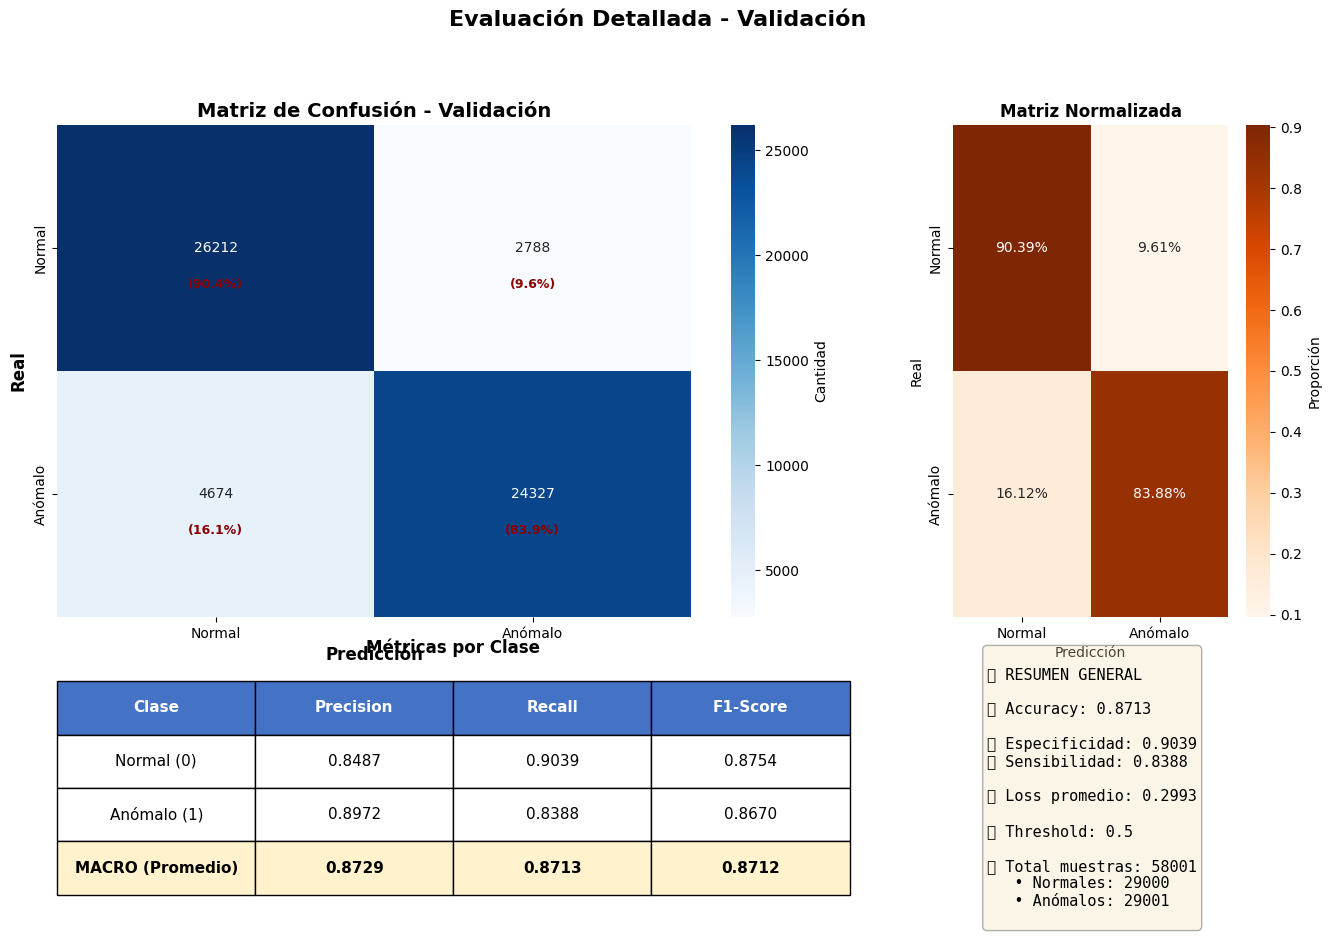

\n======================================================================
📊 MÉTRICAS DETALLADAS - Validación
\n📈 MÉTRICAS GENERALES:
   • Accuracy:      0.8713
   • Precision (Macro): 0.8729
   • Recall (Macro):    0.8713
   • F1-Score (Macro):  0.8712
   • Loss promedio:     0.2993
\n📊 MÉTRICAS POR CLASE:
\n   🔵 CLASE NORMAL (0):
      • Precision:  0.8487
      • Recall:     0.9039
      • F1-Score:   0.8754
      • Especificidad: 0.9039
\n   🔴 CLASE ANÓMALA (1):
      • Precision:  0.8972
      • Recall:     0.8388
      • F1-Score:   0.8670
      • Sensibilidad: 0.8388
\n📋 MATRIZ DE CONFUSIÓN:
              Predicción Normal    Predicción Anómalo  
   Real Normal 26212                2788                
   Real Anómalo 4674                 24327               
\n======================================================================\n
📊 Registrando métricas en MLflow (run: 8a0f4b43f26c4e87b5c9116e2413d178)...
✓ Artefactos registrados en MLflow: detailed_validation/
✓ Métricas regist

C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:227: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:235: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(figure_path, dpi=150, bbox_inches='tight')
C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:235: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(figure_path, dpi=150, bbox_inches='tight')
C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:235: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(figure_path, dpi=150, bbox_inches='tight')
C:\Users\tomas\AppData\Local\Temp\ipykernel_33168\640565492.py:235: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu

✓ Gráfico guardado: outputs\detailed_validation_test.png


C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tomas\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:

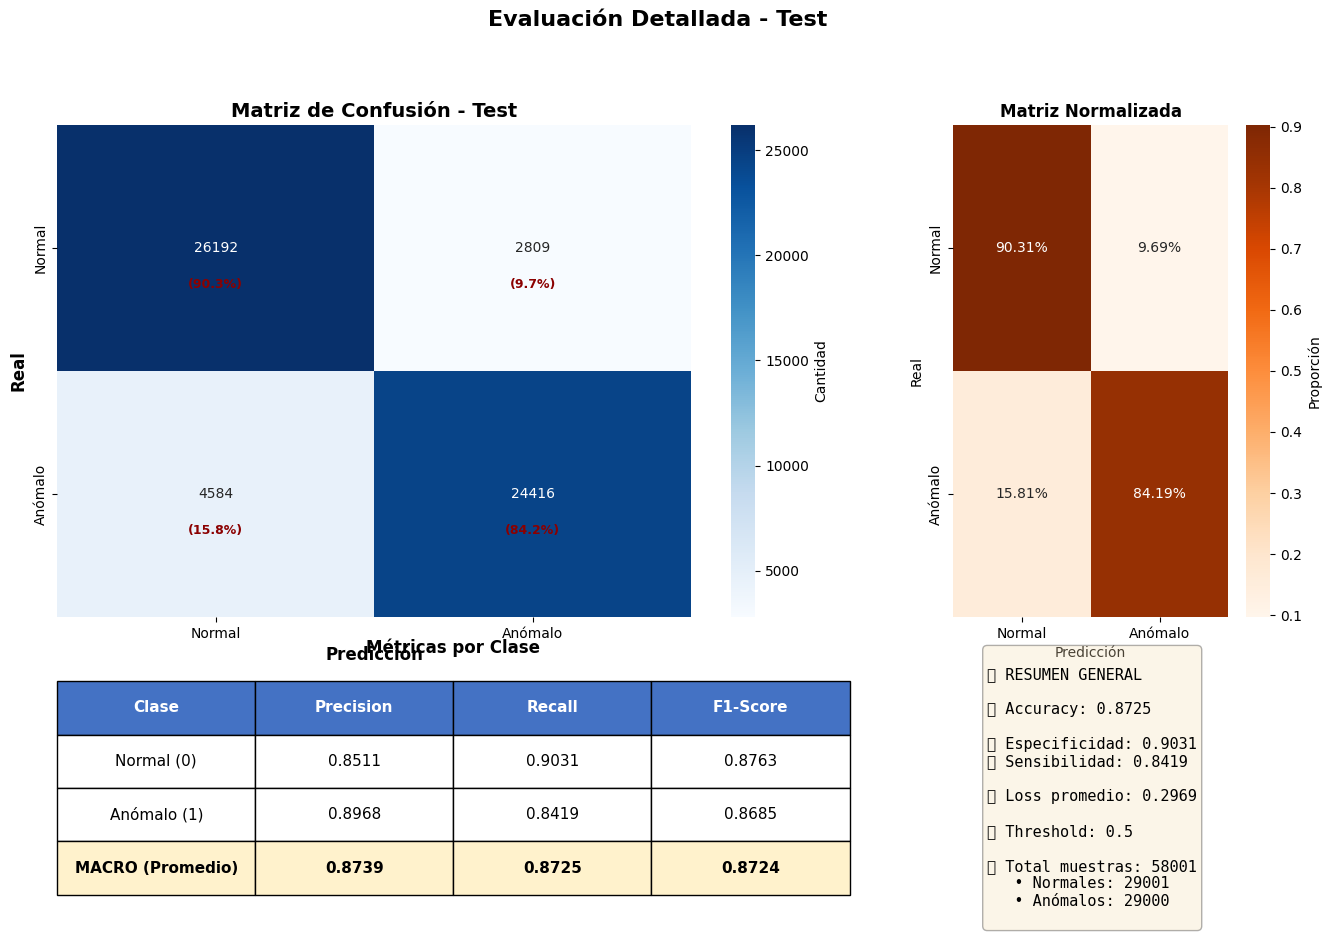

\n======================================================================
📊 MÉTRICAS DETALLADAS - Test
\n📈 MÉTRICAS GENERALES:
   • Accuracy:      0.8725
   • Precision (Macro): 0.8739
   • Recall (Macro):    0.8725
   • F1-Score (Macro):  0.8724
   • Loss promedio:     0.2969
\n📊 MÉTRICAS POR CLASE:
\n   🔵 CLASE NORMAL (0):
      • Precision:  0.8511
      • Recall:     0.9031
      • F1-Score:   0.8763
      • Especificidad: 0.9031
\n   🔴 CLASE ANÓMALA (1):
      • Precision:  0.8968
      • Recall:     0.8419
      • F1-Score:   0.8685
      • Sensibilidad: 0.8419
\n📋 MATRIZ DE CONFUSIÓN:
              Predicción Normal    Predicción Anómalo  
   Real Normal 26192                2809                
   Real Anómalo 4584                 24416               
\n======================================================================\n
📊 Registrando métricas en MLflow (run: 8a0f4b43f26c4e87b5c9116e2413d178)...
✓ Artefactos registrados en MLflow: detailed_validation/
✓ Métricas registradas 

In [47]:
# ========================================
# Ejecutar validación detallada
# ========================================
# NOTA: Ejecuta esta celda DESPUÉS de entrenar el modelo (celda 28)

# Primero ejecuta el entrenamiento si no lo has hecho:
# results = cnn1d_lstm_classification_training_flow(CONFIG)

# Luego carga los datos y ejecuta la validación:
if 'results' in locals() and 'model' in results:
    print("🔍 Ejecutando validación detallada...")
    print("="*70)
    
    # Cargar datos de validación o test
    # Puedes cambiar 'val' por 'test' si quieres evaluar en test
    DATA_DIR = CONFIG["DATA_DIR"]
    
    # Cargar datos
    X_val = torch.load(DATA_DIR / "X_val.pt", map_location='cpu')
    y_val = torch.load(DATA_DIR / "y_val.pt", map_location='cpu')
    
    # Crear DataLoader
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG["BATCH_SIZE"],
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    # Convertir y_val a numpy para las métricas
    y_val_np = y_val.numpy()
    
    # Configurar MLflow para registrar la validación
    experiment_id = setup_mlflow(CONFIG)
    
    # Ejecutar dentro de un contexto de MLflow
    with mlflow.start_run(experiment_id=experiment_id, run_name=CONFIG["RUN_NAME"] + "_validation"):
        print(f"📊 MLflow run iniciado para validación detallada")
        
        # Ejecutar validación detallada en VALIDACIÓN
        print("\\n" + "="*70)
        print("📊 VALIDACIÓN EN CONJUNTO DE VALIDACIÓN")
        print("="*70)
        val_metrics, val_preds, val_probs = detailed_validation(
            model=results["model"],
            dataloader=val_loader,
            y_true=y_val_np,
            dataset_name="Validación",
            device=DEVICE,
            threshold=0.5,
            log_to_mlflow=True,
            output_dir=CONFIG["OUTPUT_DIR"]
        )
    
        # También evaluar en TEST
        print("\\n" + "="*70)
        print("📊 VALIDACIÓN EN CONJUNTO DE TEST")
        print("="*70)
        
        X_test = torch.load(DATA_DIR / "X_test.pt", map_location='cpu')
        y_test = torch.load(DATA_DIR / "y_test.pt", map_location='cpu')
        
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(
            test_dataset,
            batch_size=CONFIG["BATCH_SIZE"],
            shuffle=False,
            num_workers=0,
            pin_memory=False
        )
        
        y_test_np = y_test.numpy()
        
        test_metrics, test_preds, test_probs = detailed_validation(
            model=results["model"],
            dataloader=test_loader,
            y_true=y_test_np,
            dataset_name="Test",
            device=DEVICE,
            threshold=0.5,
            log_to_mlflow=True,
            output_dir=CONFIG["OUTPUT_DIR"]
        )
        
        print("\\n✅ Validación detallada completada y registrada en MLflow!")
    
else:
    print("⚠️ Primero debes ejecutar el entrenamiento (celda 28)")
    print("   Ejecuta: results = cnn1d_lstm_classification_training_flow(CONFIG)")


---

## ✅ Checklist Final

Antes de ejecutar el notebook completo:

1. ✅ **Ajusta la ruta `DATA_DIR`** en la sección de configuración (debe apuntar a `Datos_supervisados/tensors_200hz`)
2. ✅ **Verifica los parámetros** en la sección de configuración (N_CHANNELS, SEQ_LEN, arquitectura CNN, etc.)
3. ✅ **Cambia el nombre del experimento MLflow** (`EXPERIMENT_NAME`) si quieres crear uno nuevo
4. ✅ **Ejecuta todas las celdas en orden** (empezando por Setup CUDA)

### 📝 Notas importantes:

- El modelo se entrena con **datos supervisados** (etiquetas 0=normal, 1=anómalo)
- Los datos se cargan desde `Datos_supervisados/tensors_200hz/` (archivos .pt)
- Arquitectura: **CNN1D** (extracción de características locales) + **LSTM** (dependencias temporales)
- Todos los artefactos (modelo, gráficos, matrices de confusión) se guardan en `OUTPUT_DIR` y en MLflow
- Las métricas se registran en MLflow: `train_loss`, `train_accuracy`, `val_*`, `test_*`
- El modelo usa **BCE Loss** (Binary Cross Entropy) para clasificación binaria


---

## 9. 💾 Guardado de Modelo

Después de entrenar, puedes guardar el modelo en diferentes formatos:
1. **Modelo estándar** - Para uso local o despliegue personalizado
2. **Modelo para AWS SageMaker** - Formato listo para desplegar en SageMaker


In [62]:
# ========================================
# Función para guardar modelo estándar
# ========================================
def save_model_standard(
    model: CNN1D_LSTMClassifier,
    config: Dict,
    output_dir: Path,
    run_name: str = None,
    include_metadata: bool = True,
):
    """
    Guarda el modelo completo y metadatos en formato estándar.
    
    Args:
        model: Modelo entrenado
        config: Diccionario de configuración
        output_dir: Directorio donde guardar
        run_name: Nombre del run (para el archivo)
        include_metadata: Si True, guarda también config.json
        
    Returns:
        Tuple con (model_path, state_dict_path, metadata_path)
    """
    from datetime import datetime
    
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    if run_name is None:
        run_name = config.get("RUN_NAME", "cnn1d_lstm_model")
    
    # 1. Guardar modelo completo (.pt) con state_dict y config
    model_path = output_dir / f"{run_name}.pt"
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'n_channels': config['N_CHANNELS'],
            'seq_len': config['SEQ_LEN'],
            'out_channels_list': config['out_channels_list'],
            'kernel_sizes': config['kernel_sizes'],
            'pool_sizes': config['pool_sizes'],
            'use_batchnorm': config['USE_BATCHNORM'],
            'cnn_activation': config['CNN_ACTIVATION'],
            'cnn_dropout': config['CNN_DROPOUT'],
            'hidden_size': config['HIDDEN_SIZE'],
            'num_layers': config['NUM_LAYERS'],
            'dropout': config['DROPOUT'],
            'fc_units': config['FC_UNITS'],
        },
        'training_config': {
            'batch_size': config['BATCH_SIZE'],
            'learning_rate': config['LEARNING_RATE'],
            'num_epochs': config['NUM_EPOCHS'],
            'weight_decay': config['WEIGHT_DECAY'],
        }
    }, model_path)
    print(f"✓ Modelo completo guardado: {model_path}")
    
    # 2. Guardar solo el state dict (más liviano)
    state_dict_path = output_dir / f"{run_name}_state_dict.pt"
    torch.save(model.state_dict(), state_dict_path)
    print(f"✓ State dict guardado: {state_dict_path}")
    
    # 3. Guardar metadatos como JSON (opcional)
    metadata_path = None
    if include_metadata:
        metadata = {
            'model_type': 'CNN1D_LSTM_Classifier',
            'run_name': run_name,
            'experiment_name': config.get('EXPERIMENT_NAME', ''),
            'date': str(datetime.now()),
            'model_config': {
                'n_channels': config['N_CHANNELS'],
                'seq_len': config['SEQ_LEN'],
                'out_channels_list': config['out_channels_list'],
                'kernel_sizes': config['kernel_sizes'],
                'pool_sizes': config['pool_sizes'],
                'use_batchnorm': config['USE_BATCHNORM'],
                'cnn_activation': config['CNN_ACTIVATION'],
                'hidden_size': config['HIDDEN_SIZE'],
                'num_layers': config['NUM_LAYERS'],
                'dropout': config['DROPOUT'],
                'fc_units': config['FC_UNITS'],
            },
            'training_config': {
                'batch_size': config['BATCH_SIZE'],
                'learning_rate': config['LEARNING_RATE'],
                'num_epochs': config['NUM_EPOCHS'],
            }
        }
        metadata_path = output_dir / f"{run_name}_metadata.json"
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)
        print(f"✓ Metadatos guardados: {metadata_path}")
    
    return model_path, state_dict_path, metadata_path


In [63]:
# ========================================
# Ejecutar guardado de modelo estándar
# ========================================
# NOTA: Ejecuta esta celda DESPUÉS de entrenar el modelo (celda 28)

# Primero ejecuta el entrenamiento si no lo has hecho:
# results = cnn1d_lstm_classification_training_flow(CONFIG)

# Luego guarda el modelo:
if 'results' in locals() and 'model' in results:
    print("💾 Guardando modelo estándar...")
    print("="*70)
    
    model_path, state_dict_path, metadata_path = save_model_standard(
        model=results["model"],
        config=CONFIG,
        output_dir=Path("./models"),
        run_name=CONFIG["RUN_NAME"],
        include_metadata=True
    )
    
    print("\n✅ Modelo estándar guardado exitosamente:")
    print(f"   📁 Directorio: {Path('./models').resolve()}")
    print(f"   📦 Modelo completo: {model_path.name}")
    print(f"   📦 State dict: {state_dict_path.name}")
    if metadata_path:
        print(f"   📄 Metadatos: {metadata_path.name}")
else:
    print("⚠️ Primero debes ejecutar el entrenamiento (celda 28)")
    print("   Ejecuta: results = cnn1d_lstm_classification_training_flow(CONFIG)")


💾 Guardando modelo estándar...
✓ Modelo completo guardado: models\cnn1d_lstm_ecg_v1.pt
✓ State dict guardado: models\cnn1d_lstm_ecg_v1_state_dict.pt
✓ Metadatos guardados: models\cnn1d_lstm_ecg_v1_metadata.json

✅ Modelo estándar guardado exitosamente:
   📁 Directorio: S:\Proyecto final\Books\models
   📦 Modelo completo: cnn1d_lstm_ecg_v1.pt
   📦 State dict: cnn1d_lstm_ecg_v1_state_dict.pt
   📄 Metadatos: cnn1d_lstm_ecg_v1_metadata.json


In [64]:
# ========================================
# Función para exportar modelo para AWS SageMaker
# ========================================
import os
import tarfile

def export_model_for_sagemaker(
    model: CNN1D_LSTMClassifier,
    config: Dict,
    output_dir: Path,
    run_name: str = None,
):
    """
    Exporta el modelo en formato listo para AWS SageMaker.
    
    Crea la estructura:
    model_package/
    ├── model.pth
    ├── config.json
    └── code/
        ├── inference.py
        └── requirements.txt
    
    Args:
        model: Modelo entrenado
        config: Diccionario de configuración
        output_dir: Directorio donde guardar
        run_name: Nombre del run
        
    Returns:
        Tuple con (model_package_dir, tar_path)
    """
    from datetime import datetime
    
    if run_name is None:
        run_name = config.get("RUN_NAME", "cnn1d_lstm_model")
    
    output_dir = Path(output_dir)
    model_package_dir = output_dir / f"sagemaker_{run_name}"
    code_dir = model_package_dir / "code"
    
    # Crear directorios
    model_package_dir.mkdir(parents=True, exist_ok=True)
    code_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Guardar modelo
    model_path = model_package_dir / "model.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'n_channels': config['N_CHANNELS'],
            'seq_len': config['SEQ_LEN'],
            'out_channels_list': config['out_channels_list'],
            'kernel_sizes': config['kernel_sizes'],
            'pool_sizes': config['pool_sizes'],
            'use_batchnorm': config['USE_BATCHNORM'],
            'cnn_activation': config['CNN_ACTIVATION'],
            'cnn_dropout': config['CNN_DROPOUT'],
            'hidden_size': config['HIDDEN_SIZE'],
            'num_layers': config['NUM_LAYERS'],
            'dropout': config['DROPOUT'],
            'fc_units': config['FC_UNITS'],
        }
    }, model_path)
    print(f"✓ Modelo guardado: {model_path}")
    
    # 2. Guardar config.json
    config_dict = {
        'model_type': 'CNN1D_LSTM_Classifier',
        'run_name': run_name,
        'experiment_name': config.get('EXPERIMENT_NAME', ''),
        'export_date': datetime.now().isoformat(),
        'model_config': {
            'n_channels': config['N_CHANNELS'],
            'seq_len': config['SEQ_LEN'],
            'out_channels_list': config['out_channels_list'],
            'kernel_sizes': config['kernel_sizes'],
            'pool_sizes': config['pool_sizes'],
            'use_batchnorm': config['USE_BATCHNORM'],
            'cnn_activation': config['CNN_ACTIVATION'],
            'cnn_dropout': config['CNN_DROPOUT'],
            'hidden_size': config['HIDDEN_SIZE'],
            'num_layers': config['NUM_LAYERS'],
            'dropout': config['DROPOUT'],
            'fc_units': config['FC_UNITS'],
        }
    }
    config_path = model_package_dir / "config.json"
    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config_dict, f, indent=2, ensure_ascii=False)
    print(f"✓ Config guardado: {config_path}")
    
    # 3. Crear inference.py (script de inferencia para SageMaker)
    inference_code = '''"""
Script de inferencia para AWS SageMaker.
SageMaker llama a estas funciones automáticamente.
"""
import os
import json
import torch
import torch.nn as nn
import numpy as np


# ========================================
# Definición del modelo
# ========================================
class CNN1D_LSTMClassifier(nn.Module):
    def __init__(
        self,
        n_channels: int,
        seq_len: int,
        out_channels_list: list,
        kernel_sizes: list,
        pool_sizes: list,
        use_batchnorm: bool = True,
        cnn_activation: str = "relu",
        cnn_dropout: float = 0.0,
        hidden_size: int = 64,
        num_layers: int = 2,
        dropout: float = 0.2,
        fc_units: int = 32,
    ):
        super().__init__()
        self.n_channels = n_channels
        self.seq_len = seq_len
        
        # CNN1D Blocks
        cnn_layers = []
        in_channels = n_channels
        for i, (out_channels, kernel_size, pool_size) in enumerate(
            zip(out_channels_list, kernel_sizes, pool_sizes)
        ):
            cnn_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2))
            if use_batchnorm:
                cnn_layers.append(nn.BatchNorm1d(out_channels))
            if cnn_activation == "relu":
                cnn_layers.append(nn.ReLU())
            if cnn_dropout > 0:
                cnn_layers.append(nn.Dropout(cnn_dropout))
            if pool_size is not None and pool_size > 1:
                cnn_layers.append(nn.MaxPool1d(pool_size))
            in_channels = out_channels
        
        self.cnn = nn.Sequential(*cnn_layers)
        
        # Calcular tamaño de salida de CNN
        with torch.no_grad():
            dummy_input = torch.zeros(1, n_channels, seq_len)
            cnn_output = self.cnn(dummy_input)
            self.cnn_output_channels = cnn_output.shape[1]
            self.cnn_output_seq_len = cnn_output.shape[2]
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True,
        )
        
        # Fully Connected
        self.fc1 = nn.Linear(hidden_size, fc_units)
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_units, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.shape) == 3 and x.shape[1] == self.seq_len and x.shape[2] == self.n_channels:
            x = x.transpose(1, 2)
        
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.transpose(1, 2)
        
        lstm_out, (hidden, cell) = self.lstm(cnn_out)
        last_hidden = hidden[-1]
        
        out = self.fc1(last_hidden)
        out = self.relu(out)
        out = self.dropout_fc(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out.squeeze(-1)


# ========================================
# Funciones requeridas por SageMaker
# ========================================
def model_fn(model_dir):
    """Carga el modelo desde el directorio."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    config_path = os.path.join(model_dir, "config.json")
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    model_config = config['model_config']
    
    model = CNN1D_LSTMClassifier(
        n_channels=model_config['n_channels'],
        seq_len=model_config['seq_len'],
        out_channels_list=model_config['out_channels_list'],
        kernel_sizes=model_config['kernel_sizes'],
        pool_sizes=model_config['pool_sizes'],
        use_batchnorm=model_config['use_batchnorm'],
        cnn_activation=model_config['cnn_activation'],
        cnn_dropout=model_config.get('cnn_dropout', 0.0),
        hidden_size=model_config['hidden_size'],
        num_layers=model_config['num_layers'],
        dropout=model_config['dropout'],
        fc_units=model_config['fc_units'],
    )
    
    model_path = os.path.join(model_dir, "model.pth")
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.to(device)
    model.eval()
    
    return model


def input_fn(request_body, request_content_type):
    """Preprocesa la entrada."""
    if request_content_type == 'application/json':
        data = json.loads(request_body)
        if 'signals' in data:
            signals = np.array(data['signals'], dtype=np.float32)
        elif 'signal' in data:
            signals = np.array([data['signal']], dtype=np.float32)
        else:
            signals = np.array(data, dtype=np.float32)
            if len(signals.shape) == 2:
                signals = signals[np.newaxis, :, :]
        
        return torch.from_numpy(signals)
    
    elif request_content_type == 'application/x-npy':
        import io
        array = np.load(io.BytesIO(request_body))
        if len(array.shape) == 2:
            array = array[np.newaxis, :, :]
        return torch.from_numpy(array.astype(np.float32))
    
    else:
        raise ValueError(f"Content type {request_content_type} no soportado")


def predict_fn(input_data, model):
    """Hace la predicción."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        if not isinstance(input_data, torch.Tensor):
            input_data = torch.tensor(input_data, dtype=torch.float32)
        
        input_data = input_data.to(device)
        probabilities = model(input_data)
        
        if isinstance(probabilities, torch.Tensor):
            probabilities = probabilities.cpu().numpy()
    
    return probabilities


def output_fn(prediction, accept):
    """Formatea la salida."""
    if accept == 'application/json':
        if isinstance(prediction, (list, np.ndarray)):
            result = {
                'predictions': prediction.tolist() if isinstance(prediction, np.ndarray) else prediction,
                'probabilities': prediction.tolist() if isinstance(prediction, np.ndarray) else prediction
            }
        else:
            result = {'prediction': float(prediction), 'probability': float(prediction)}
        
        return json.dumps(result)
    
    elif accept == 'text/csv':
        return ','.join([str(p) for p in prediction])
    
    else:
        return json.dumps({'predictions': prediction.tolist() if isinstance(prediction, np.ndarray) else [float(prediction)]})
'''
    
    inference_path = code_dir / "inference.py"
    with open(inference_path, 'w', encoding='utf-8') as f:
        f.write(inference_code)
    print(f"✓ Inference script creado: {inference_path}")
    
    # 4. Crear requirements.txt
    requirements = """torch>=2.0.0
numpy>=1.24.0
"""
    requirements_path = code_dir / "requirements.txt"
    with open(requirements_path, 'w', encoding='utf-8') as f:
        f.write(requirements)
    print(f"✓ Requirements creado: {requirements_path}")
    
    # 5. Crear archivo tar.gz para SageMaker
    tar_path = output_dir / f"{run_name}_sagemaker.tar.gz"
    with tarfile.open(tar_path, "w:gz") as tar:
        tar.add(model_package_dir, arcname=os.path.basename(model_package_dir))
    print(f"✓ Archivo comprimido creado: {tar_path}")
    
    print(f"\n✅ Modelo exportado para SageMaker:")
    print(f"   📁 Directorio: {model_package_dir.resolve()}")
    print(f"   📦 Archivo tar.gz: {tar_path.resolve()}")
    print(f"\n📤 Para subir a SageMaker:")
    print(f"   1. Sube {tar_path.name} a S3")
    print(f"   2. Usa el URI de S3 para crear el modelo en SageMaker")
    print(f"   3. Ejemplo: s3://tu-bucket/models/{tar_path.name}")
    
    return model_package_dir, tar_path


In [ ]:
# ========================================
# Ejecutar exportación para AWS SageMaker
# ========================================
# NOTA: Ejecuta esta celda DESPUÉS de entrenar el modelo (celda 28)

# Primero ejecuta el entrenamiento si no lo has hecho:
# results = cnn1d_lstm_classification_training_flow(CONFIG)

# Luego exporta para SageMaker:
if 'results' in locals() and 'model' in results:
    print("🚀 Exportando modelo para AWS SageMaker...")
    print("="*70)
    
    model_package_dir, tar_path = export_model_for_sagemaker(
        model=results["model"],
        config=CONFIG,
        output_dir=Path("./sagemaker_models"),
        run_name=CONFIG["RUN_NAME"]
    )
    
    print("\n✅ Modelo exportado exitosamente para AWS SageMaker!")
    print(f"\n📦 Siguiente paso: Sube el archivo {tar_path.name} a S3")
    print(f"   Luego crea el modelo en SageMaker usando el URI de S3")
else:
    print("⚠️ Primero debes ejecutar el entrenamiento (celda 28)")
    print("   Ejecuta: results = cnn1d_lstm_classification_training_flow(CONFIG)")


🚀 Exportando modelo para AWS SageMaker...
✓ Modelo guardado: sagemaker_models\sagemaker_cnn1d_lstm_ecg_v1\model.pth
✓ Config guardado: sagemaker_models\sagemaker_cnn1d_lstm_ecg_v1\config.json
✓ Inference script creado: sagemaker_models\sagemaker_cnn1d_lstm_ecg_v1\code\inference.py
✓ Requirements creado: sagemaker_models\sagemaker_cnn1d_lstm_ecg_v1\code\requirements.txt
✓ Archivo comprimido creado: sagemaker_models\cnn1d_lstm_ecg_v1_sagemaker.tar.gz

✅ Modelo exportado para SageMaker:
   📁 Directorio: S:\Proyecto final\Books\sagemaker_models\sagemaker_cnn1d_lstm_ecg_v1
   📦 Archivo tar.gz: S:\Proyecto final\Books\sagemaker_models\cnn1d_lstm_ecg_v1_sagemaker.tar.gz

📤 Para subir a SageMaker:
   1. Sube cnn1d_lstm_ecg_v1_sagemaker.tar.gz a S3
   2. Usa el URI de S3 para crear el modelo en SageMaker
   3. Ejemplo: s3://tu-bucket/models/cnn1d_lstm_ecg_v1_sagemaker.tar.gz

✅ Modelo exportado exitosamente para AWS SageMaker!

📦 Siguiente paso: Sube el archivo cnn1d_lstm_ecg_v1_sagemaker.tar.g

: 

---

## 10. 🔬 Prueba de Predicciones con Ejemplos

Esta sección te permite probar el modelo con ejemplos específicos (10 normales y 10 anómalos) y visualizar las predicciones.


In [57]:
# ========================================
# Función para probar modelo con ejemplos uno por uno (con botones interactivos)
# ========================================
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    IPYWIDGETS_AVAILABLE = True
except ImportError:
    print("⏳ Instalando ipywidgets...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets"])
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    IPYWIDGETS_AVAILABLE = True

def test_model_with_examples_interactive(
    model: CNN1D_LSTMClassifier,
    X_data: torch.Tensor,
    y_true: torch.Tensor,
    n_normal: int = 10,
    n_anomalous: int = 10,
    dataset_name: str = "Test",
    device: torch.device = None,
    threshold: float = 0.5,
    sample_rate: int = 200,  # Hz
):
    """
    Prueba el modelo con ejemplos específicos mostrándolos uno por uno de forma interactiva.
    
    Args:
        model: Modelo entrenado
        X_data: Tensor con señales ECG (N, seq_len, channels)
        y_true: Tensor con etiquetas verdaderas (N,)
        n_normal: Número de ejemplos normales a mostrar
        n_anomalous: Número de ejemplos anómalos a mostrar
        dataset_name: Nombre del dataset
        device: Dispositivo (CPU/GPU)
        threshold: Umbral para clasificación binaria
        sample_rate: Frecuencia de muestreo en Hz (para el eje X)
    
    Returns:
        Diccionario con resultados y datos de los ejemplos seleccionados
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    model.eval()
    
    # Convertir a numpy para facilitar el manejo
    X_np = X_data.numpy() if isinstance(X_data, torch.Tensor) else X_data
    y_np = y_true.numpy() if isinstance(y_true, torch.Tensor) else y_true
    
    # Separar normales y anómalos
    normal_indices = np.where(y_np == 0)[0]
    anomalous_indices = np.where(y_np == 1)[0]
    
    # Seleccionar ejemplos aleatorios
    if len(normal_indices) >= n_normal:
        selected_normal = np.random.choice(normal_indices, n_normal, replace=False)
    else:
        selected_normal = normal_indices
        n_normal = len(selected_normal)
    
    if len(anomalous_indices) >= n_anomalous:
        selected_anomalous = np.random.choice(anomalous_indices, n_anomalous, replace=False)
    else:
        selected_anomalous = anomalous_indices
        n_anomalous = len(selected_anomalous)
    
    # Combinar ejemplos seleccionados
    selected_indices = np.concatenate([selected_normal, selected_anomalous])
    selected_X = X_np[selected_indices]
    selected_y = y_np[selected_indices]
    
    # Hacer predicciones
    print(f"🔬 Probando modelo con {n_normal} normales y {n_anomalous} anómalos...")
    print("="*70)
    
    with torch.no_grad():
        X_tensor = torch.from_numpy(selected_X).float().to(device)
        probabilities = model(X_tensor).cpu().numpy()
        predictions = (probabilities > threshold).astype(int)
    
    # Preparar datos para visualización interactiva
    seq_len = selected_X.shape[1]
    time_axis = np.arange(seq_len) / sample_rate  # Tiempo en segundos
    n_total = n_normal + n_anomalous
    
    # Colores para cada lead
    lead_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Azul, Naranja, Verde
    lead_names = ['II', 'V1', 'V5']
    
    # Contadores
    correct_count = 0
    incorrect_count = 0
    for pred_label, true_label in zip(predictions, selected_y):
        if pred_label == true_label:
            correct_count += 1
        else:
            incorrect_count += 1
    
    # Variable para mantener el índice actual
    current_idx = [0]  # Usar lista para poder modificar desde funciones internas
    
    # Área de salida para mostrar gráficos
    output = widgets.Output()
    
    # Función para mostrar un ejemplo
    def show_example(idx):
        """Muestra un ejemplo específico."""
        if idx < 0:
            idx = n_total - 1
        elif idx >= n_total:
            idx = 0
        current_idx[0] = idx
        
        true_label = selected_y[idx]
        pred_label = predictions[idx]
        prob = probabilities[idx]
        i = selected_indices[idx]
        
        # Determinar si la predicción es correcta
        is_correct = (pred_label == true_label)
        title_color = 'green' if is_correct else 'red'
        status = '✓ CORRECTO' if is_correct else '✗ INCORRECTO'
        
        with output:
            clear_output(wait=True)
            
            # Crear figura
            fig, axes = plt.subplots(3, 1, figsize=(14, 10))
            fig.suptitle(
                f'Ejemplo {idx+1}/{n_total} - {dataset_name} | '
                f'Índice en dataset: {i}',
                fontsize=14,
                fontweight='bold'
            )
            
            # Plotear cada derivación en un subplot separado
            for channel in range(3):
                ax = axes[channel]
                signal = selected_X[idx, :, channel]
                ax.plot(time_axis, signal, color=lead_colors[channel], linewidth=1.5)
                ax.set_title(f'Derivación {lead_names[channel]}', fontsize=12, fontweight='bold')
                ax.set_xlabel('Tiempo (s)', fontsize=10)
                ax.set_ylabel('Amplitud (normalizada)', fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.set_xlim(0, time_axis[-1])
            
            # Información general en el título principal
            true_class = "NORMAL" if true_label == 0 else "ANÓMALO"
            pred_class = "NORMAL" if pred_label == 0 else "ANÓMALO"
            
            info_text = (
                f"Etiqueta Real: {true_class} | "
                f"Predicción: {pred_class} | "
                f"Probabilidad: {prob:.4f} ({prob*100:.2f}%) | "
                f"{status}"
            )
            
            fig.text(0.5, 0.02, info_text, ha='center', fontsize=12, 
                    fontweight='bold', color=title_color,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            # Añadir fondo de color según predicción
            for ax in axes:
                if pred_label == 1:  # Anómalo
                    ax.axhspan(ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.03, color='red')
                else:  # Normal
                    ax.axhspan(ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.03, color='green')
            
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.08)
            plt.show()
            
            # Imprimir información detallada
            print(f"{'='*70}")
            print(f"📊 EJEMPLO {idx+1}/{n_total}")
            print(f"{'='*70}")
            print(f"Índice en dataset: {i}")
            print(f"Etiqueta Real: {true_class}")
            print(f"Predicción del modelo: {pred_class}")
            print(f"Probabilidad: {prob:.4f} ({prob*100:.2f}%)")
            print(f"Resultado: {status}")
            print(f"{'='*70}")
    
    # Funciones de navegación
    def on_next(b):
        current_idx[0] = (current_idx[0] + 1) % n_total
        show_example(current_idx[0])
        slider.value = current_idx[0]
    
    def on_prev(b):
        current_idx[0] = (current_idx[0] - 1) % n_total
        show_example(current_idx[0])
        slider.value = current_idx[0]
    
    def on_slider_change(change):
        show_example(change['new'])
    
    # Crear widgets
    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=n_total-1,
        step=1,
        description='Ejemplo:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )
    
    prev_button = widgets.Button(
        description='◀ Anterior',
        button_style='info',
        icon='backward',
        layout=widgets.Layout(width='120px', height='40px')
    )
    
    next_button = widgets.Button(
        description='Siguiente ▶',
        button_style='info',
        icon='forward',
        layout=widgets.Layout(width='120px', height='40px')
    )
    
    # Crear label con información
    info_label = widgets.HTML(
        value=f"<b>Total: {n_total} ejemplos ({n_normal} normales, {n_anomalous} anómalos) | "
              f"Correctos: {correct_count}/{n_total} ({correct_count/n_total*100:.1f}%)</b>",
        layout=widgets.Layout(margin='10px 0px')
    )
    
    # Conectar callbacks
    prev_button.on_click(on_prev)
    next_button.on_click(on_next)
    slider.observe(on_slider_change, names='value')
    
    # Crear layout de botones
    button_box = widgets.HBox([prev_button, slider, next_button], 
                              layout=widgets.Layout(justify_content='center', margin='10px 0px'))
    
    # Mostrar primer ejemplo
    show_example(0)
    
    # Mostrar interfaz interactiva
    print(f"\\n{'='*70}")
    print(f"🔬 MODO INTERACTIVO - {dataset_name}")
    print(f"{'='*70}")
    print(f"Total de ejemplos: {n_total} ({n_normal} normales, {n_anomalous} anómalos)")
    print(f"Accuracy en estos ejemplos: {correct_count}/{n_total} ({correct_count/n_total*100:.1f}%)")
    print(f"\\n💡 Usa los botones o el slider para navegar entre ejemplos")
    print(f"{'='*70}\\n")
    
    # Mostrar widgets
    display(info_label)
    display(button_box)
    display(output)
    
    # Retornar datos y controles para uso adicional
    return {
        'show_example': show_example,
        'current_idx': current_idx,
        'n_total': n_total,
        'indices': selected_indices,
        'true_labels': selected_y,
        'predictions': predictions,
        'probabilities': probabilities,
        'selected_X': selected_X,
        'time_axis': time_axis,
        'accuracy': correct_count / n_total,
        'correct_count': correct_count,
        'incorrect_count': incorrect_count,
        'dataset_name': dataset_name,
        'slider': slider,
        'prev_button': prev_button,
        'next_button': next_button
    }


In [62]:
# ========================================
# Ejecutar prueba interactiva con ejemplos
# ========================================
# NOTA: Ejecuta esta celda DESPUÉS de entrenar el modelo (celda 28)

if 'results' in locals() and 'model' in results:
    print("🔬 Probando modelo con ejemplos específicos (modo interactivo)...")
    print("="*70)
    
    # Cargar datos de test
    DATA_DIR = CONFIG["DATA_DIR"]
    X_test = torch.load(DATA_DIR / "X_test.pt", map_location='cpu')
    y_test = torch.load(DATA_DIR / "y_test.pt", map_location='cpu')
    
    # Probar con 10 normales y 10 anómalos del conjunto de test
    print("\\n📊 Preparando ejemplos del conjunto de TEST")
    print("="*70)
    
    test_results = test_model_with_examples_interactive(
        model=results["model"],
        X_data=X_test,
        y_true=y_test,
        n_normal=10,
        n_anomalous=10,
        dataset_name="Test",
        device=DEVICE,
        threshold=0.5,
        sample_rate=200  # 200 Hz según tu configuración
    )
    
    print(f"\\n✅ Ejemplos cargados. Usa los botones o el slider arriba para navegar.")
    
else:
    print("⚠️ Primero debes ejecutar el entrenamiento (celda 28)")
    print("   Ejecuta: results = cnn1d_lstm_classification_training_flow(CONFIG)")


🔬 Probando modelo con ejemplos específicos (modo interactivo)...
\n📊 Preparando ejemplos del conjunto de TEST
🔬 Probando modelo con 10 normales y 10 anómalos...


\n======================================================================
🔬 MODO INTERACTIVO - Test
Total de ejemplos: 20 (10 normales, 10 anómalos)
Accuracy en estos ejemplos: 18/20 (90.0%)
\n💡 Usa los botones o el slider para navegar entre ejemplos
======================================================================\n


HTML(value='<b>Total: 20 ejemplos (10 normales, 10 anómalos) | Correctos: 18/20 (90.0%)</b>', layout=Layout(ma…

Output()

\n✅ Ejemplos cargados. Usa los botones o el slider arriba para navegar.


In [60]:
# ========================================
# Nota: La navegación ya está disponible arriba con botones interactivos
# ========================================
# Los botones y el slider están en la celda anterior.
# Puedes usar también estos comandos adicionales si necesitas:

if 'test_results' in locals():
    print("💡 Comandos adicionales disponibles:")
    print(f"   • test_results['slider'].value = 5  - Ir directamente al ejemplo 5")
    print(f"   • test_results['next_button'].click()  - Simular clic en siguiente")
    print(f"   • test_results['show_example'](10)  - Mostrar ejemplo 10 directamente")
else:
    print("⚠️ Primero ejecuta la celda anterior para cargar los ejemplos")


💡 Comandos adicionales disponibles:
   • test_results['slider'].value = 5  - Ir directamente al ejemplo 5
   • test_results['next_button'].click()  - Simular clic en siguiente
   • test_results['show_example'](10)  - Mostrar ejemplo 10 directamente
